# Implementing uncertainty associated with f-factor estimates to summarize data using the Kent distribution

This notebook develops the method that is now implemented in ```ipmag.find_ei_kent``` and described in the text in order to incorporate inclination flattening uncertainty in paleomagnetic poles. This approach takes the f factors that are output from E/I bootstraps to estimate the elliptical shape of the Kent distribution that can summarize the uncertainty associated with inclination shallowing. The notebook also implements a compilation based approach that develops this Kent distribution uncertainty estimate from resampling the f factors within the compilation developed in this study. This method is implemented in the ```ipmag.find_compilation_kent``` function.

## Import scientific Python packages

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import mode
import pandas as pd

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib

import cartopy.crs as ccrs
#import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D

%config InlineBackend.figure_format = 'retina'

In [15]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 10)

## functions for plotting spherical direction distributions and contours

In [2]:
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=100, **kwargs):

    cmap=kwargs.get('cmap', 'viridis')

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree())
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.95], colors=kwargs.get('colors', 'k'), transform=ccrs.PlateCarree(), 
                       linewidths=kwargs.get('lw', 1), zorder = kwargs.get('zorder', 100))
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=kwargs.get('color', 'C0'), alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

## Import data and filter to the `ht` (DRM) component

In [3]:
Cutface_specimens = pd.read_csv('../data/Pmag/cutface/specimens_w_strat_gs.txt', sep='\t', header=1)

Cutface_lat = 47.73055
Cutface_lon = -90.44128

Cutface_specimens['slat'] = Cutface_lat
Cutface_specimens['slon'] = Cutface_lon

specimens_ht_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==100)]
mean_ht = ipmag.fisher_mean(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist())

specimens_ht_tc['plon'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[0]
specimens_ht_tc['plat'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[1]

uncorrected_mean_pole = ipmag.fisher_mean(dec=specimens_ht_tc['plon'].tolist(), inc=specimens_ht_tc['plat'].tolist())
ipmag.print_pole_mean(uncorrected_mean_pole)

Plon: 178.5  Plat: 23.0
Number of directions in mean (n): 157
Angular radius of 95% confidence (A_95): 1.7
Precision parameter (k) estimate: 44.0


In [4]:
uncorrected_plon, uncorrected_plat, A95 = np.round([uncorrected_mean_pole['dec'], uncorrected_mean_pole['inc'], uncorrected_mean_pole['alpha95']],1)
uncorrected_plon, uncorrected_plat, A95

(178.5, 23.0, 1.7)

Bootstrapping.... be patient

The original inclination was: 29.43

The corrected inclination is: 40.74
with bootstrapped confidence bounds of: 33.49 to 48.04
and elongation parameter of: 1.93
The flattening factor is: 0.64
with bootstrapped confidence bounds of: 0.85 to 0.51


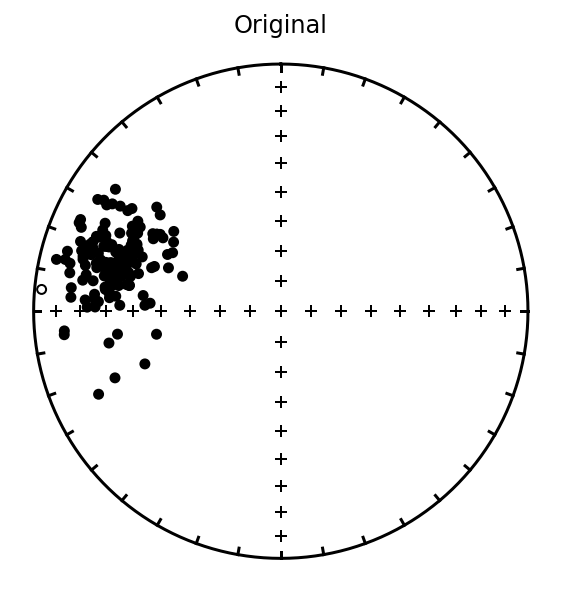

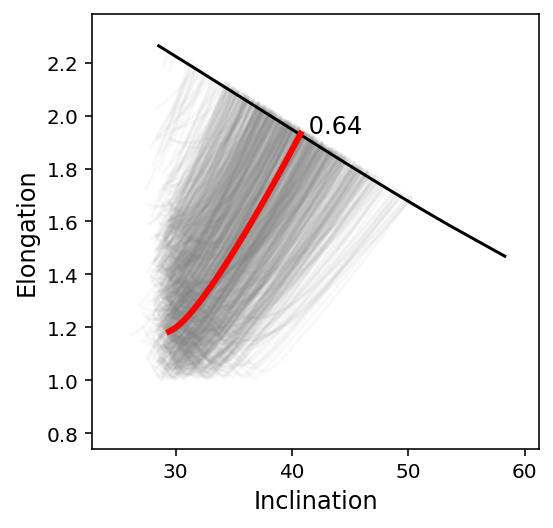

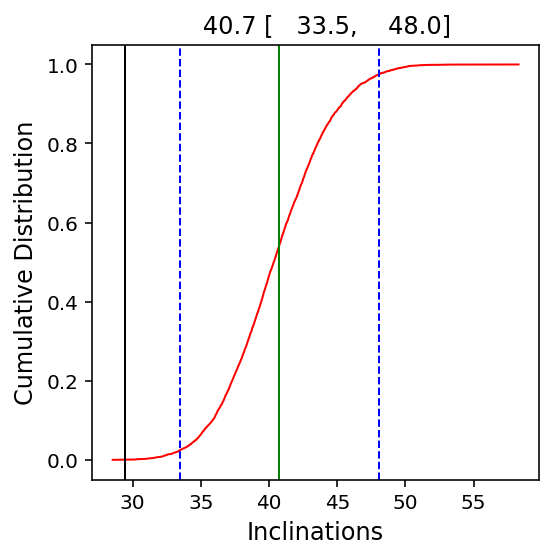

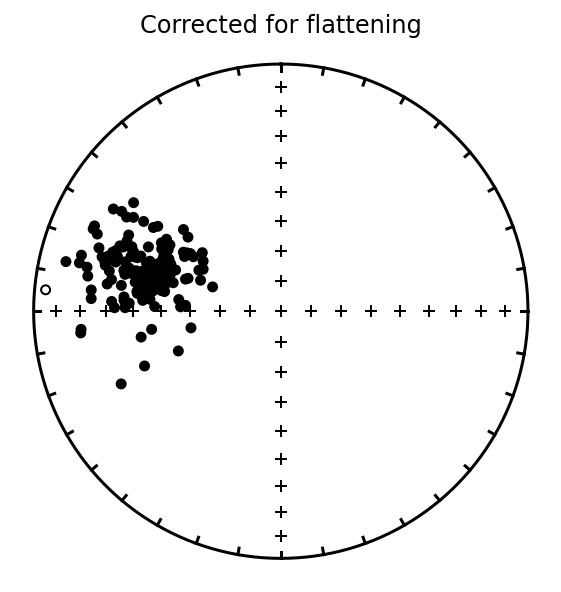

In [10]:
EI_incs, EI_elongs, EI_fs = ipmag.find_ei(specimens_ht_tc[['dir_dec', 'dir_inc']].to_numpy(), nb=5000, 
                                    return_values = 1, save=0, save_folder='../code_output', fmt='png', tight_axes=1)

### show all unsquished directions according to E/I bootstrap results

note - make sure to reduce the amount of f used in the equal area plot, otherwise the cell will hang due to too many directions to plot

In [6]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()

plt.figure(figsize=(6,6))
ipmag.plot_net()
cNorm  = matplotlib.colors.Normalize(vmin=min(EI_fs), vmax=max(EI_fs))
f_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for f in EI_fs[::5]:
    rgba = f_scalarMap.to_rgba(f)
    hex_color = colors.rgb2hex(rgba)
    
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    ipmag.plot_di(specimens_ht_tc_decs, unsquish_incs, color = hex_color, alpha=0.02)
cb = plt.colorbar(f_scalarMap,orientation='horizontal',fraction=0.05, pad=0.05)
cb.ax.tick_params(labelsize=14)
cb.ax.set_title(label='$f$ values', fontsize=14);
# plt.savefig('../code_output/bootstrap_directions.png', dpi=300, bbox_inches='tight')

### transform these directions to VGPs and calculate the mean poles

In [7]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)

ipmag.plot_pole(m, Cutface_lon, Cutface_lat, 0, label='Cut Face Creek site location', color='r', edgecolor='none', marker = '*', markersize=200)

for f in EI_fs[::5]:
    rgba = f_scalarMap.to_rgba(f)
    hex_color = colors.rgb2hex(rgba)
    
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    ipmag.plot_vgp(m, unsquish_lons, unsquish_lats, color = 'lightgray', edge=None, markersize=5, alpha=0.01)

    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    ipmag.plot_pole(m, unsquish_VGPs_mean['dec'], unsquish_VGPs_mean['inc'], unsquish_VGPs_mean['alpha95'], 
                    color=hex_color, edgecolor='none', markersize=5, mean_alpha=1, A95_alpha=1)
# plt.savefig('../code_output/bootstrap_poles.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 576x576 with 0 Axes>

### resample poles from the Fisher means associated with each f factor to get the distribution of poles

<Figure size 576x576 with 0 Axes>

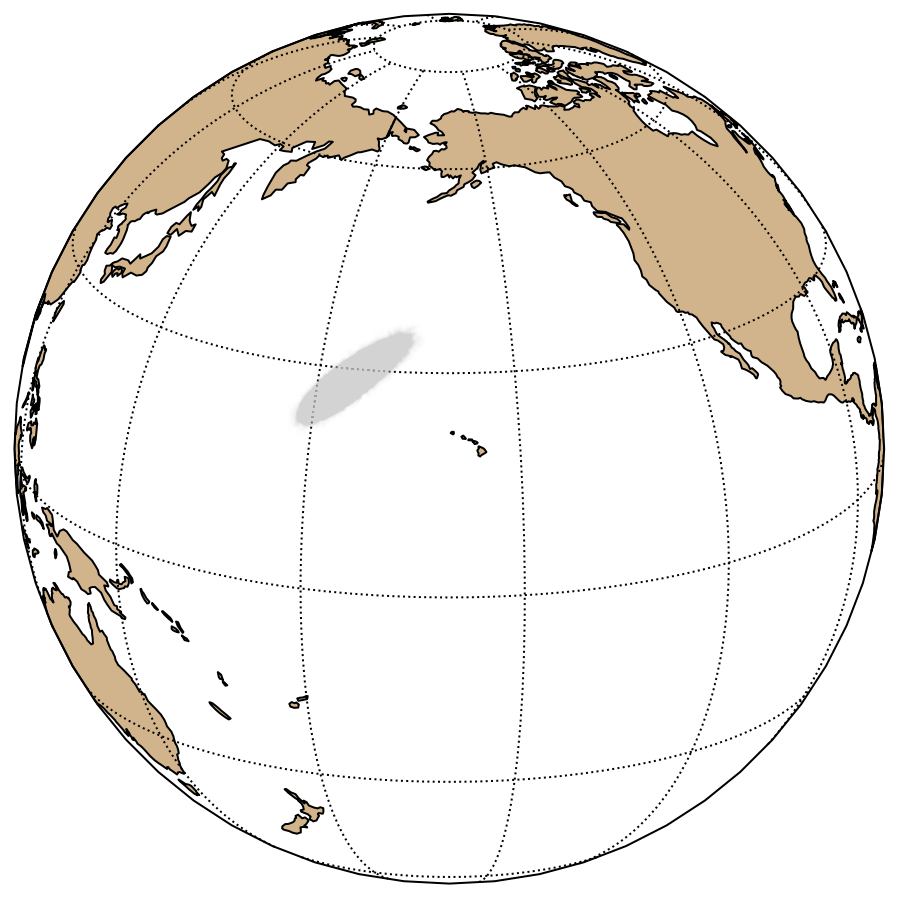

In [8]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

mean_lons = []
mean_lats = []

for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=unsquish_VGPs_mean['alpha95'], n=100, 
                                                   dec=unsquish_VGPs_mean['dec'], inc=unsquish_VGPs_mean['inc'], di_block=0)
    mean_lons.extend(resampled_lons)
    mean_lats.extend(resampled_lats)

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(m, mean_lons, mean_lats, color='lightgrey', edge='none', markersize=5, alpha=0.02)

# plt.savefig('../code_output/bootstrap_pole_resample.png', dpi=300, bbox_inches='tight')

### calculate the Kent distribution from these resampled pole positions

In [9]:
kent_distribution_95 = ipmag.kent_distribution_95(dec=mean_lons,inc=mean_lats) 
kent_distribution_95

{'dec': 184.36657278498808,
 'inc': 28.117293140114572,
 'n': 500000,
 'Zdec': 297.88070719144963,
 'Zinc': 36.74766090450513,
 'Edec': 67.32418607705381,
 'Einc': 40.393287670582765,
 'Zeta': 6.687624432387529,
 'Eta': 1.8323099797216333,
 'R1': 0.9987837388196703,
 'R2': 0.002087837407589571}

In [10]:
ipmag.print_kent_mean(kent_distribution_95)

Plon: 184.4  Plat: 28.1
Major axis lon: 297.9  Major axis lat: 36.7
Minor axis lon: 67.3  Minor axis lat: 40.4
Major axis angle of 95% ellipse (Zeta): 6.7
Minor axis angle of 95% ellipse (Eta): 1.8
Number of directions in mean (n): 500000


### plot the 95% distribution along with the Kent mean pole

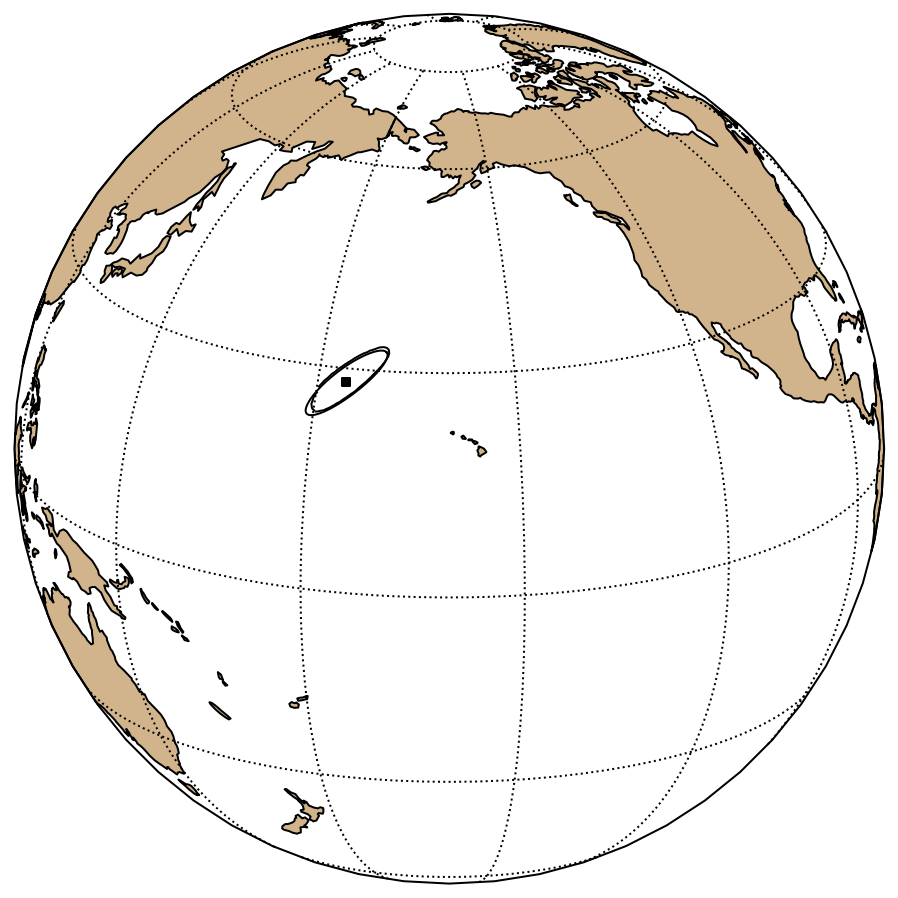

In [11]:
m = ipmag.make_orthographic_map(200, 20)
plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 400, cmap='viridis')
ipmag.plot_pole_ellipse(m,kent_distribution_95)
plt.show()

### visualize the axes of the Kent mean

In [12]:
map_axis = ipmag.make_orthographic_map(central_longitude=180,central_latitude=55,figsize=(10, 8))
ipmag.plot_vgp(map_axis,vgp_lon=kent_distribution_95['dec'],vgp_lat=kent_distribution_95['inc'],
               color='black',markersize=40,label='mean pole ($\gamma_1$)')
ipmag.plot_vgp(map_axis,vgp_lon=kent_distribution_95['Zdec'],vgp_lat=kent_distribution_95['Zinc'],
               color='C1',markersize=40,label='major axis ($\gamma_2$)')
ipmag.plot_vgp(map_axis,vgp_lon=kent_distribution_95['Edec'],vgp_lat=kent_distribution_95['Einc'],
               color='C0',markersize=40,label='minor axis ($\gamma_3$)')
map_axis.plot([kent_distribution_95['Edec'],kent_distribution_95['dec']],
              [kent_distribution_95['Einc'],kent_distribution_95['inc']],transform=ccrs.Geodetic())
map_axis.plot([kent_distribution_95['Zdec'],kent_distribution_95['dec']],
              [kent_distribution_95['Zinc'],kent_distribution_95['inc']],transform=ccrs.Geodetic())
ipmag.plot_pole_ellipse(map_axis,kent_distribution_95)
plt.legend()
plt.show()

### plot the resampled pole positions along with the 95% contour and the Kent mean distribution

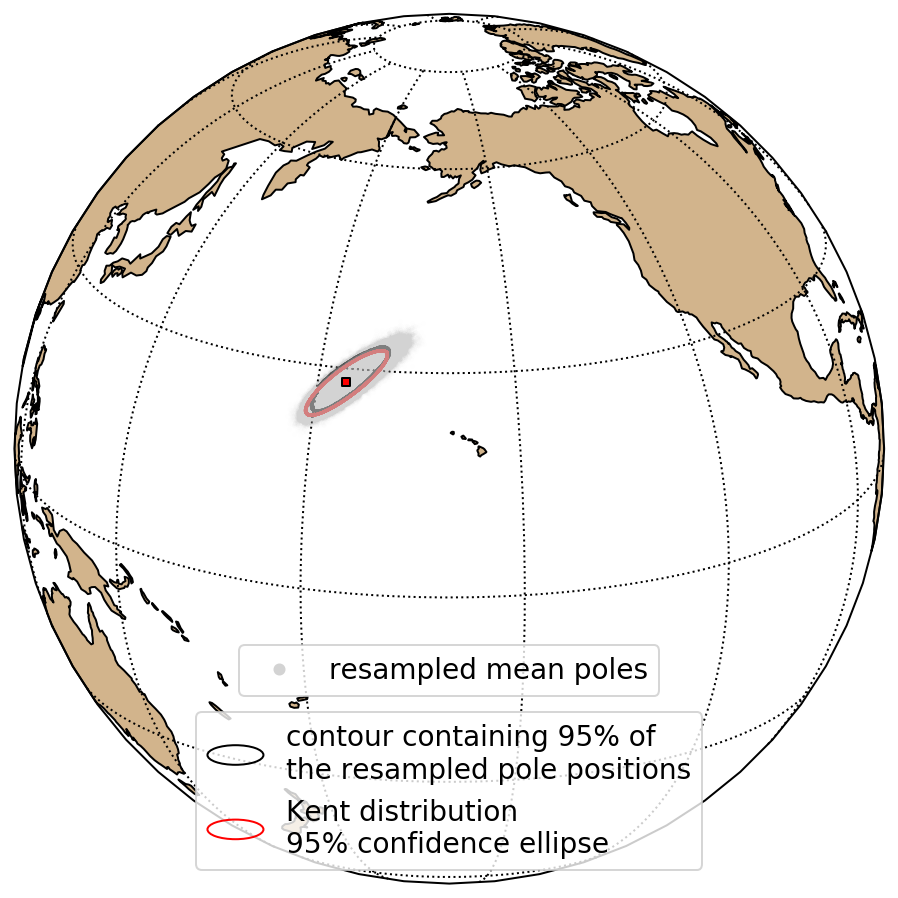

In [13]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(m, mean_lons, mean_lats, color='lightgray', edge='none', markersize=5, alpha=0.01)

plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 400, colors='k', lw=2, zorder = 2)
ipmag.plot_pole_ellipse(m,kent_distribution_95, color='red', lw=2)
# ipmag.plot_pole(m,uncorrected_plon, uncorrected_plat, 1.8, color='orange', label='uncorrected ')

# m.legend()
ellipse_colors = ["k","r"]
texts = ["contour containing 95% of\nthe resampled pole positions", "Kent distribution\n95% confidence ellipse"]
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


c = [mpatches.Circle((0.5, 0.5), 1, edgecolor=ellipse_colors[i], facecolor='none',linewidth=1) for i in range(len(texts))]
legend_1 = plt.legend(handles=[Line2D([], [], color='lightgray', marker='o', markersize=5, lw=0,
                         label='resampled mean poles')], bbox_to_anchor=[0.5, 0.2], loc=8, fontsize=14)
plt.gca().add_artist(legend_1)
plt.legend(c,texts, loc='lower center', ncol=1, handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=14)
# print(c)
# plt.savefig('../code_output/Kent_ellipse.png', bbox_inches='tight', dpi=300)
plt.show()

## make find_compilation_kent function that generates Kent mean with uncertainty for legacy sedimentary paleomagnetic poles using f factors from the compilation

If we are in a situation where we only have site location, an uncorrected pole location and Fisher A95 stats for a legacy sedimentary pole, we can generate a Kent distribution representing flattening uncertainty by resampling f factors from the f factor compilation. The approach for estimating the ellipical uncertainty is the same as above, but rather than taking the f factors from the E/I analysis they are taken from the compilation.

### import the compilation file

In [14]:
def find_compilation_kent(plon, plat, A95, slon, slat, f_from_compilation=None, n=10000, n_fish=100, 
                          return_poles=False, return_kent_stats=True):
    '''
    Applies flattening factors from the compilation to sedimentary paleomagnetic pole where only 
    pole longitude, pole latitude, A95, site longitude, site latitude, are available. 
    
    First calculate the paleomagnetic direction at the site of the mean pole using plon, plat using 
    pmag.vgp_di. Then draw n resamples from the compiled f values in the compilation. The default
    compilation of Pierce et al., 2022 can be used or the user can provide their own compilation.
    
    Unsquish the directions with the resampled f factors, then convert the mean directions back to pole space.
    Making the simplifying assumtpion that A95 is the same as the directions are unflattened.
    Resample n_fish mean poles from the fisher distribution given the unsquished plon, plat, and A95
    This will result in a total of n*n_fish number of resampled mean poles
    Summarize the distribution of the mean poles using a Kent distribution 
    
    Parameters
    -----------
    plon: legacy mean pole longitude
    plat: legacy mean pole latitude
    A95: legacy mean pole A95 
    slon: site longitude
    slat: site latitude
    f_from_compilation: list of f factors (default is None in which case compilation of 
        Pierce et al., 2022 Table S1 will be used)
    n: number of resample from compilation (default is 10000)
    n_fish: number of resamples from each Fisher mean pole position (default is 100)
    return_poles: whether or not to return the resampled mean pole positions (default is False)
    return_kent_stats: whether or not to return the calculate kent disttribution statistics of the resampled mean poles
        (default is True)
    '''

    # get the uncorrected dec and inc from a given paleomagnetic pole
    original_dec, original_inc = pmag.vgp_di(plat, plon, slat, slon)
    
    if f_from_compilation==None:
    # compilation f value list
        f_from_compilation = pd.Series([0.49, 0.77, 0.63, 0.59, 0.57, 0.4, 0.63, 0.66, 0.63, 0.49, 0.49, 0.58, 0.54, 0.73, 0.97, 
                                        0.59, 0.84, 0.9, 0.78, 0.83, 0.58, 0.94, 0.78, 0.9, 0.68, 0.48, 0.67, 0.66, 0.7, 0.43, 
                                        0.45, 0.58, 0.58, 0.53, 0.42, 0.51, 0.61, 0.52, 0.62, 0.73, 0.66, 0.55, 0.47, 0.77, 
                                        0.62, 0.54, 0.46, 0.56, 0.64, 0.47, 0.48, 0.44, 0.52, 0.65, 0.81, 0.64, 0.71, 
                                        0.79, 0.65, 0.56, 0.69, 0.43, 0.7, 0.67, 0.65, 0.49, 0.54, 0.64, 0.83, 0.68])
    else:
        f_from_compilation = pd.Series(f_from_compilation)
        
    f_resample=f_from_compilation.sample(n=n, replace=1).tolist()
    
    plt.figure(figsize=(6,6))
    plt.hist(f_resample, alpha=0.6, density=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('resample of compilation f factors', fontsize=16)
    plt.ylabel('density', fontsize=16)
    
    #calculate corrected inclinations
    compilation_incs = [pmag.unsquish(original_inc, f) for f in f_resample]
    # calculate corrected paleolatitudes
    compilation_paleolats = np.degrees(np.arctan(np.tan(np.radians(compilation_incs))/2))
    
    plt.figure(figsize=(6,6))
    plt.hist(compilation_paleolats, alpha=0.6, density=1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('compilation paleolatitudes ($^\circ$)', fontsize=16)
    plt.ylabel('density', fontsize=16)
    
    compilation_mean_lons = []
    compilation_mean_lats = []

    for i in range(len(f_from_compilation)):
        unsquish_plon, unsquish_plats,_,_ = pmag.dia_vgp(original_dec, compilation_incs[i], A95, slat, slon)
        resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=A95, n=n_fish, 
                                                       dec=unsquish_plon, inc=unsquish_plats, di_block=0)
        compilation_mean_lons.extend(resampled_lons)
        compilation_mean_lats.extend(resampled_lats)

    m = ipmag.make_orthographic_map(200, 20)
    ipmag.plot_vgp(m, compilation_mean_lons, compilation_mean_lats, color='lightgrey', edge='none', markersize=5, alpha=0.002)
    
    f_compilation_kent_distribution_95 = ipmag.kent_distribution_95(dec=compilation_mean_lons, 
                                                                inc=compilation_mean_lats) 
    ipmag.print_kent_mean(f_compilation_kent_distribution_95)
    ipmag.plot_pole_ellipse(m,f_compilation_kent_distribution_95, color='darkred', label='Kent mean pole')
    ipmag.plot_pole(m, plon, plat, A95, label='uncorrected pole position', color='C0')
    plt.legend(loc=8, fontsize=14)
    
    if return_poles and return_kent_stats:
        return compilation_mean_lons, compilation_mean_lats, f_compilation_kent_distribution_95
    elif return_poles:
        return compilation_mean_lons, compilation_mean_lats
    elif return_kent_stats:
        return f_compilation_kent_distribution_95

### f compilation values from supplementary table S1

In [15]:
all_f = [0.49, 0.77, 0.63, 0.59, 0.57, 0.4, 0.63, 0.66, 0.63, 0.49, 0.49, 0.58, 0.54, 0.73, 0.97, 
                          0.59, 0.84, 0.9, 0.78, 0.83, 0.58, 0.94, 0.78, 0.9, 0.68, 0.48, 0.67, 0.66, 0.7, 0.43, 
                          0.45, 0.58, 0.58, 0.53, 0.42, 0.51, 0.61, 0.52, 0.62, 0.73, 0.66, 0.55, 0.47, 0.77, 
                          0.62, 0.54, 0.46, 0.56, 0.64, 0.47, 0.48, 0.44, 0.52, 0.65, 0.81, 0.64, 0.71, 
                          0.79, 0.65, 0.56, 0.69, 0.43, 0.7, 0.67, 0.65, 0.49, 0.54, 0.64, 0.83, 0.68]

hematite_f = [0.49, 0.77, 0.57, 0.4, 0.63, 0.66, 0.63, 0.49, 0.49, 0.58, 0.54, 0.84, 0.9, 0.48, 0.66, 0.58, 
              0.53, 0.42, 0.46, 0.56, 0.64, 0.47, 0.48, 0.44, 0.52, 0.65, 0.64, 0.43, 0.49, 0.54, 0.64, 0.83]
magnetite_f = [0.97, 0.59, 0.94, 0.7, 0.43, 0.58, 0.51, 0.47, 0.77, 0.62, 0.54, 0.81, 0.71, 0.79, 0.65, 0.56, 0.69, 0.7, 0.67, 0.65]
mixed_f =  [0.63, 0.59, 0.73, 0.78, 0.83, 0.58, 0.78, 0.9, 0.68, 0.67, 0.45, 0.61, 0.52, 0.62, 0.73, 0.66, 0.55, 0.68]

### Kent ellipse of Cut Face using all compilation f

Plon: 185.7  Plat: 29.3
Major axis lon: 299.8  Major axis lat: 36.0
Minor axis lon: 67.6  Minor axis lat: 40.1
Major axis angle of 95% ellipse (Zeta): 10.8
Minor axis angle of 95% ellipse (Eta): 1.7
Number of directions in mean (n): 70000


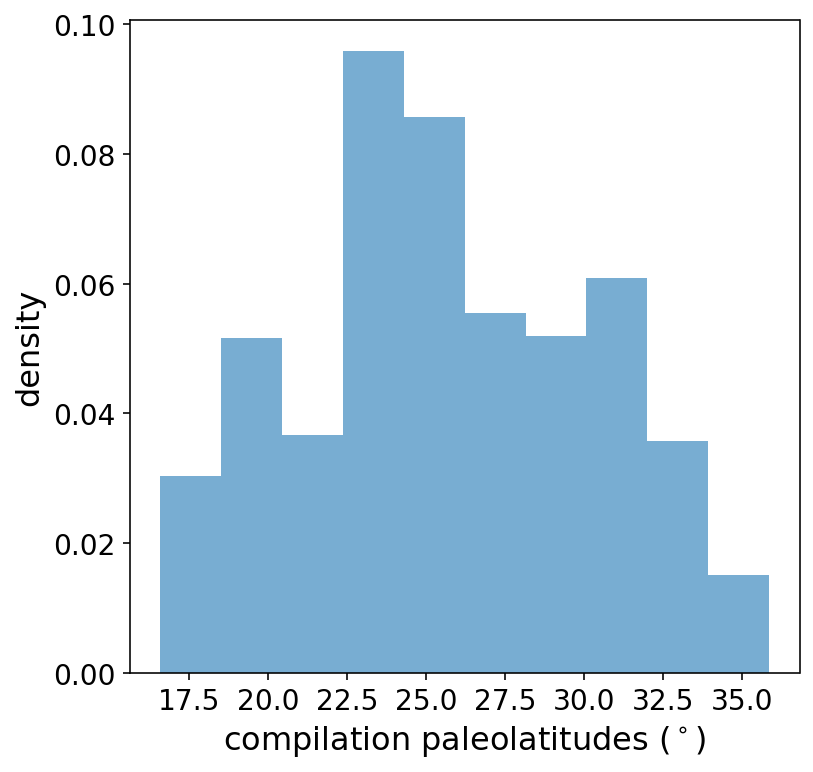

In [28]:
f_compilation_kent_distribution_95_all = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                               A95, Cutface_lon, Cutface_lat, 
                                                               f_from_compilation=all_f,
                                                               n=10000, n_fish=1000)

In [29]:
ipmag.print_kent_mean(f_compilation_kent_distribution_95_all)

Plon: 185.7  Plat: 29.3
Major axis lon: 299.8  Major axis lat: 36.0
Minor axis lon: 67.6  Minor axis lat: 40.1
Major axis angle of 95% ellipse (Zeta): 10.8
Minor axis angle of 95% ellipse (Eta): 1.7
Number of directions in mean (n): 70000


### Kent ellipse of Cut Face using hematite compilation f

Plon: 188.0  Plat: 31.0
Major axis lon: 302.3  Major axis lat: 34.4
Minor axis lon: 67.6  Minor axis lat: 40.1
Major axis angle of 95% ellipse (Zeta): 11.3
Minor axis angle of 95% ellipse (Eta): 1.7
Number of directions in mean (n): 32000


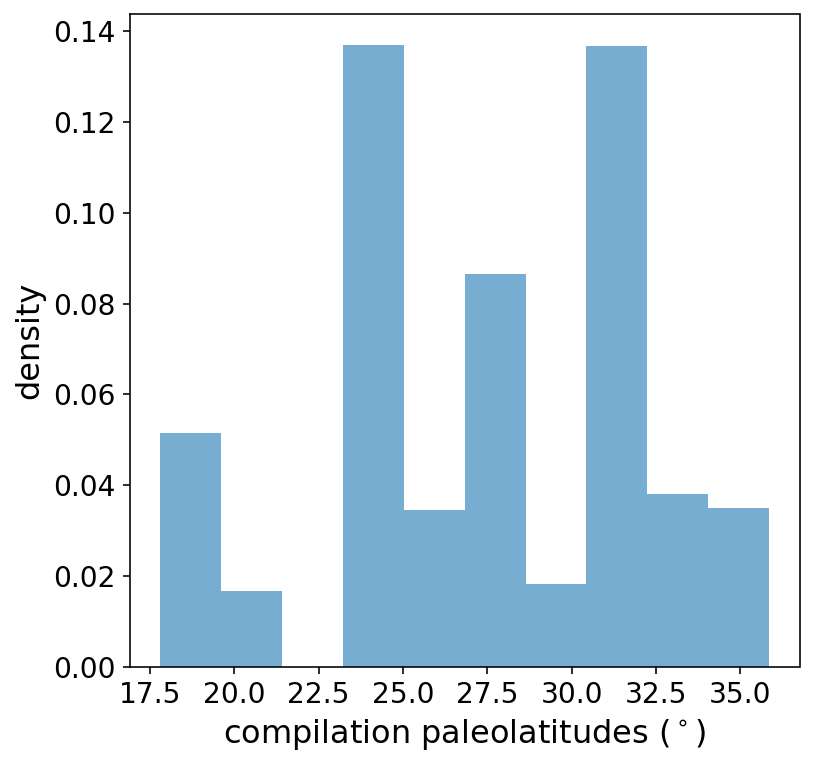

In [18]:
f_compilation_kent_distribution_95_hem = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                               A95, Cutface_lon, Cutface_lat, 
                                                               f_from_compilation=hematite_f, n=10000, n_fish=1000)

### Kent ellipse of Cut Face using magnetite compilation f

Plon: 184.5  Plat: 28.3
Major axis lon: 298.2  Major axis lat: 36.8
Minor axis lon: 67.4  Minor axis lat: 40.2
Major axis angle of 95% ellipse (Zeta): 10.7
Minor axis angle of 95% ellipse (Eta): 1.7
Number of directions in mean (n): 20000


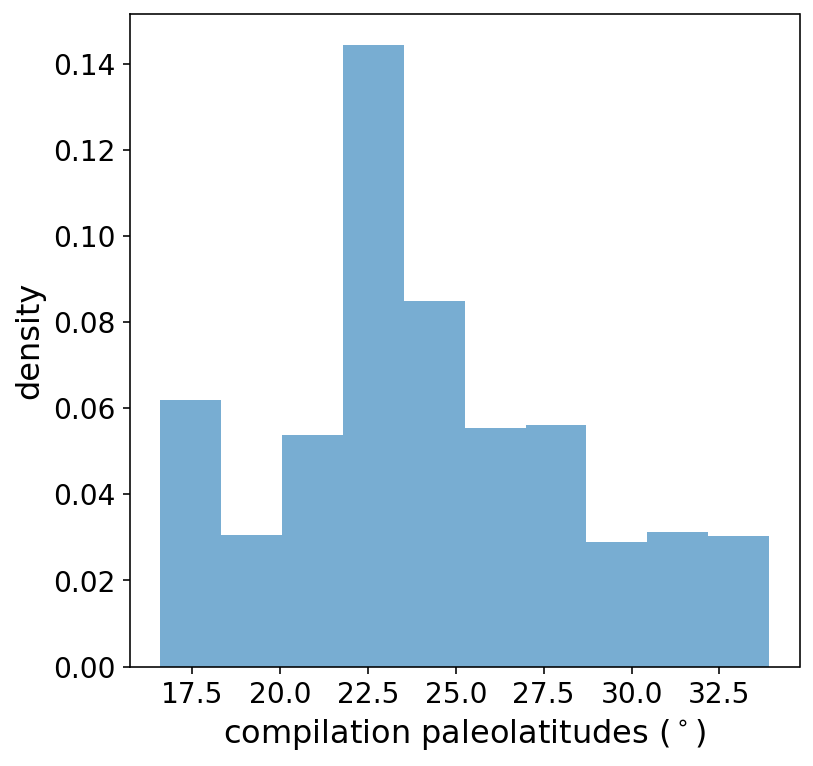

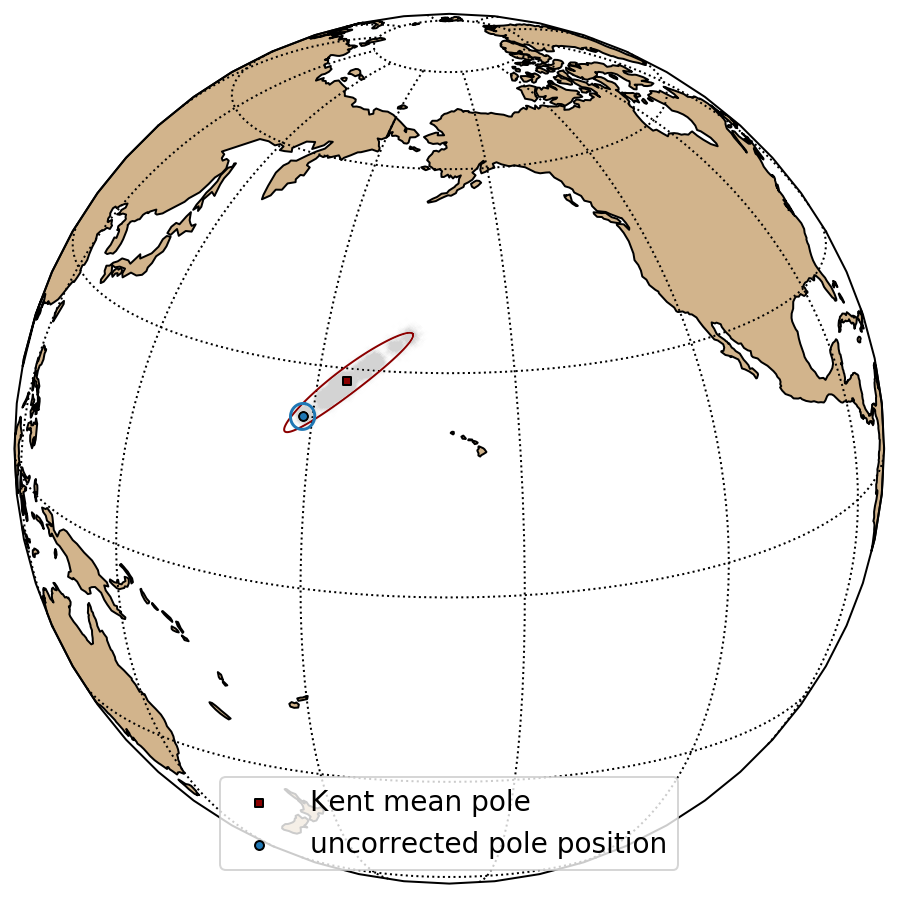

In [19]:
f_compilation_kent_distribution_95_mag = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                               A95, Cutface_lon, Cutface_lat, 
                                                               f_from_compilation=magnetite_f, n=10000, n_fish=1000)

### Kent ellipse of Cut Face using mixed mineralogy compilation f

Plon: 185.1  Plat: 28.8
Major axis lon: 299.1  Major axis lat: 36.5
Minor axis lon: 67.6  Minor axis lat: 40.1
Major axis angle of 95% ellipse (Zeta): 10.1
Minor axis angle of 95% ellipse (Eta): 1.7
Number of directions in mean (n): 18000


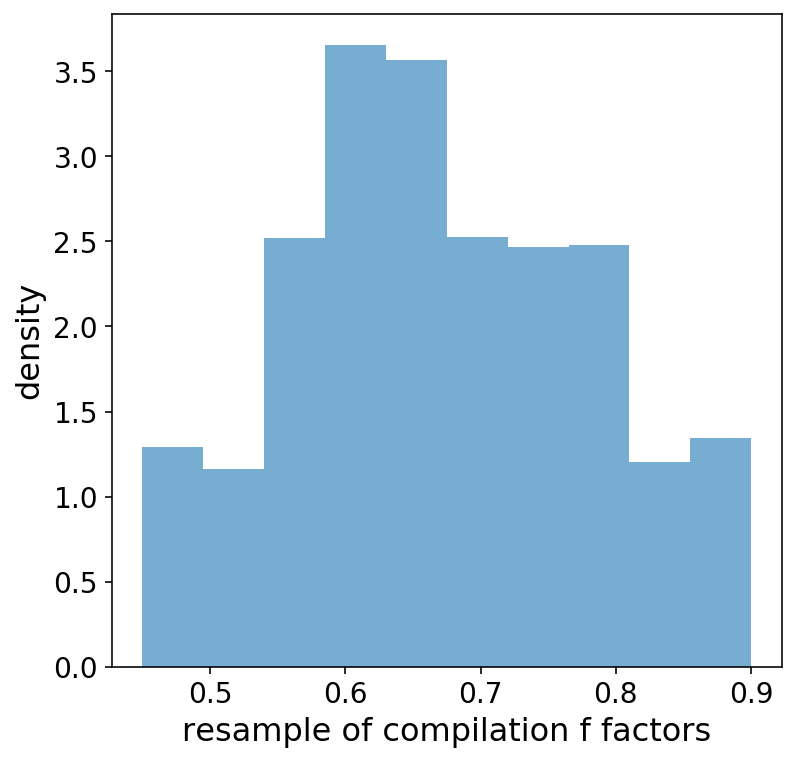

In [20]:
f_compilation_kent_distribution_95_mixed = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                                 A95, Cutface_lon, Cutface_lat, 
                                                                 f_from_compilation=mixed_f, n=10000, n_fish=1000)

### calculate the Kent mean direction and associated f factor associated with the compilation Kent mean

Here we calculate the implied f factor from the Kent mean developed using the resample of the all f factor compilation.

In [21]:
compilation_kent_mean_dec, compilation_kent_mean_inc = pmag.vgp_di(f_compilation_kent_distribution_95_all['inc'], f_compilation_kent_distribution_95_all['dec'], Cutface_lat, Cutface_lon)
np.round(np.tan(np.radians(mean_ht['inc']))/np.tan(np.radians(compilation_kent_mean_inc)),2)

0.6

### now let's calculate the arc distance between the uncorrected mean pole and Kent mean pole

In [22]:
Kent_Fisher_arc_distance = pmag.angle([uncorrected_plon, uncorrected_plat], [f_compilation_kent_distribution_95_all['dec'], f_compilation_kent_distribution_95_all['inc']])
np.round(Kent_Fisher_arc_distance,2)

array([9.2])

In [23]:
compilation_kent_mean_inc

43.42807872749839

In [24]:
Kent_plat_high = pmag.plat(compilation_kent_mean_inc)+Kent_Fisher_arc_distance+A95
Kent_pinc_high = np.degrees(np.arctan(np.tan(np.radians(Kent_plat_high))*2))
np.round(np.tan(np.radians(mean_ht['inc']))/np.tan(np.radians(Kent_pinc_high)),2)

array([0.38])

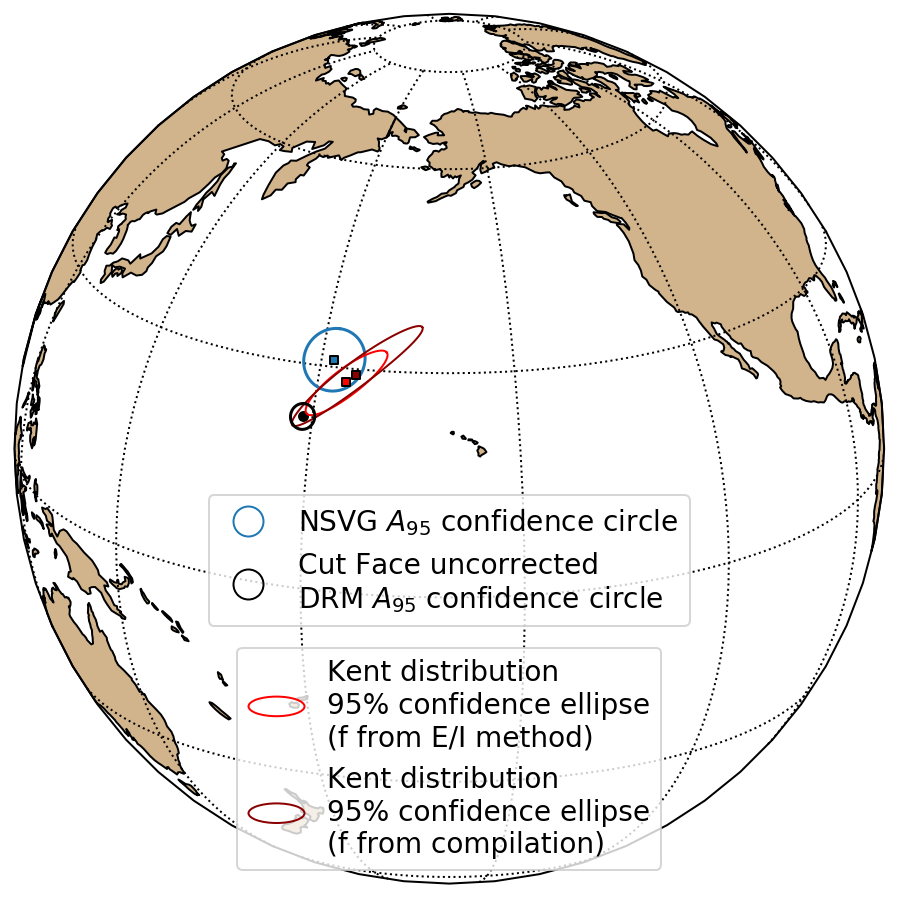

In [31]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='C0')
ipmag.plot_pole_ellipse(m,kent_distribution_95, color='r')
ipmag.plot_pole_ellipse(m,f_compilation_kent_distribution_95_all, color='darkred')
# ipmag.plot_pole_ellipse(m,f_compilation_kent_distribution_95_regulated, color='darkred')

ipmag.plot_pole(m,uncorrected_plon, uncorrected_plat, A95, color='k', label='uncorrected ')

# legend_1 = plt.legend([Line2D([0], [0], marker='o', color='k', markerfacecolor="none")],[], loc='lower center', fontsize=14)

circle_NSVG = Line2D([0], [0], marker='o', color='C0', label='NSVG $A _{95}$ confidence circle',
                        markerfacecolor='none', markersize=15, ls='none')
circle_uncorrected = Line2D([0], [0], marker='o', color='k', label='Cut Face uncorrected\nDRM $A _{95}$ confidence circle',
                        markerfacecolor='none', markersize=15, ls='none')

legend_1 = plt.legend(handles=[circle_NSVG, circle_uncorrected], bbox_to_anchor=[0.5, 0.28], loc=8, fontsize=14)
plt.gca().add_artist(legend_1)
plt.legend([mpatches.Circle((0.5, 0.5), 1, edgecolor='r', facecolor='none',linewidth=1), 
           mpatches.Circle((0.5, 0.5), 1, edgecolor='darkred', facecolor='none',linewidth=1)],
           ['Kent distribution\n95% confidence ellipse\n(f from E/I method)', 
            'Kent distribution\n95% confidence ellipse\n(f from compilation)'], loc='lower center', 
           handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=14)


plt.savefig('./code_output/Cutface_NSVG_pole_comparison.pdf', bbox_inches='tight')

## Difference in shallowing as a function of grain size

In [5]:
cf_fm_grain=Cutface_specimens[(Cutface_specimens['primary_grain_size']>=3) & 
                                                  (Cutface_specimens['dir_comp']=='ht')&
                                                  (Cutface_specimens['dir_tilt_correction']==100)]

cf_vfs_grain=Cutface_specimens[(Cutface_specimens['primary_grain_size']==2) & 
                                               (Cutface_specimens['dir_comp']=='ht')&
                                               (Cutface_specimens['dir_tilt_correction']==100)]

cf_silt_grain=Cutface_specimens[(Cutface_specimens['primary_grain_size']<=1) & 
                                                (Cutface_specimens['dir_comp']=='ht')&
                                                (Cutface_specimens['dir_tilt_correction']==100)]

Bootstrapping.... be patient



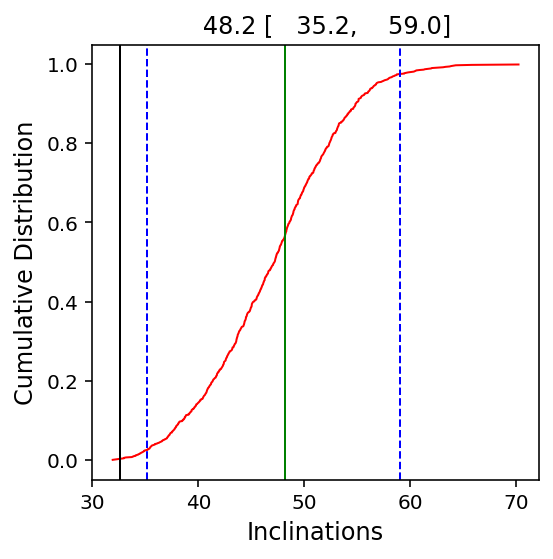

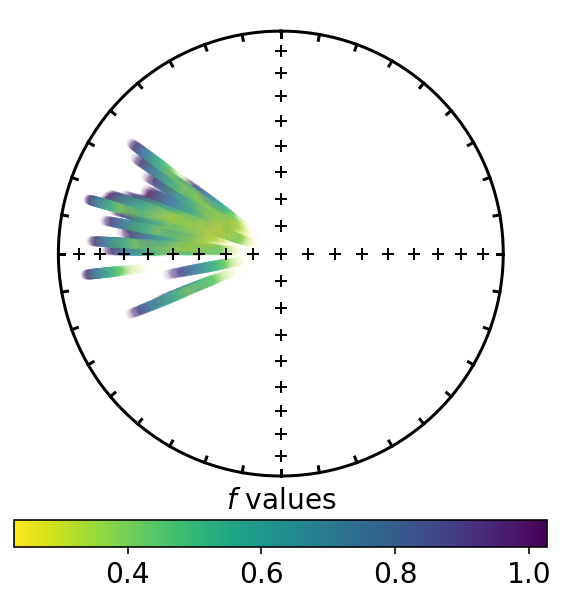

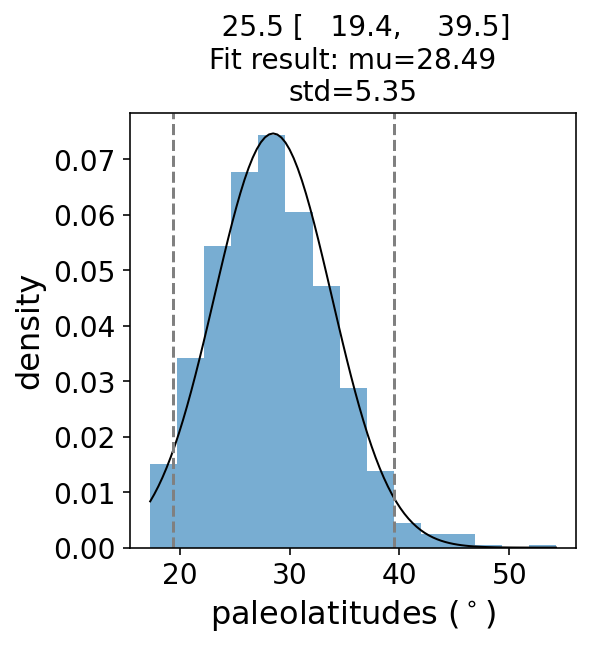

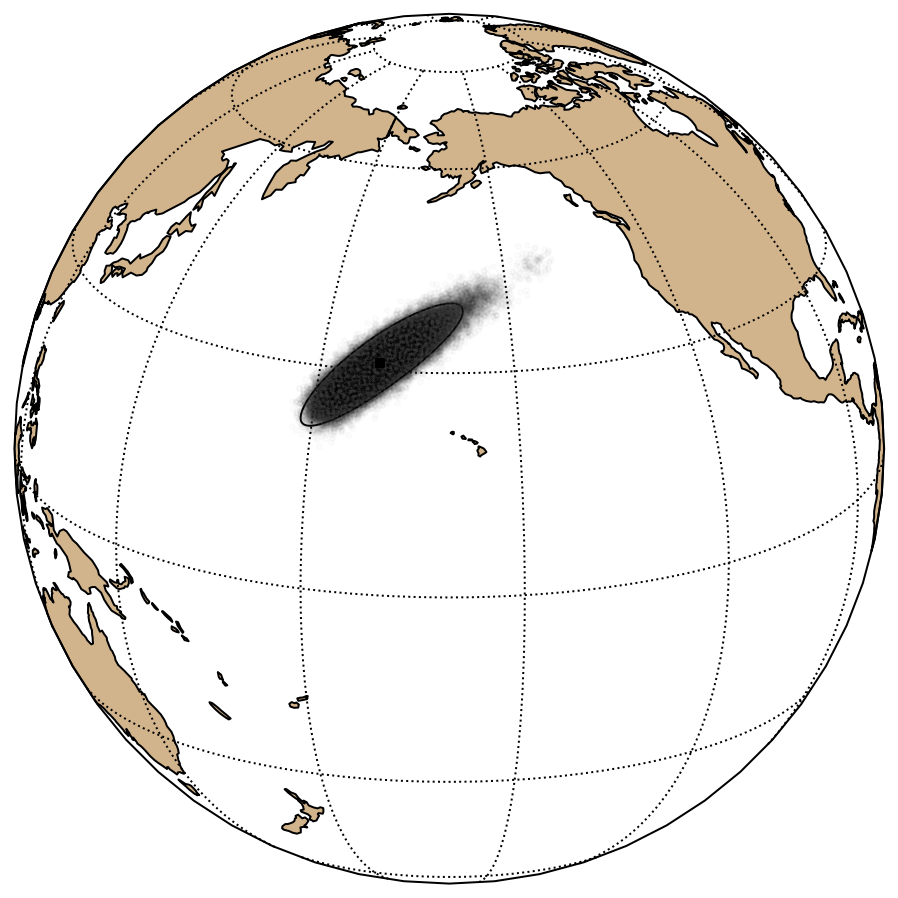

The original inclination was: 32.62

The corrected inclination is: 48.21
with bootstrapped confidence bounds of: 35.2 to 59.0
and elongation parameter of: 1.74
The flattening factor is: 0.55
with bootstrapped confidence bounds of: 0.91 to 0.38

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 189.3  Plat: 31.1
Major axis lon: 303.1  Major axis lat: 33.8
Minor axis lon: 68.1  Minor axis lat: 40.6
Major axis angle of 95% ellipse (Zeta): 13.1
Minor axis angle of 95% ellipse (Eta): 3.3
Number of directions in mean (n): 100000


In [7]:
fm_result_dir, fm_kent_stats, fm_I, fm_E, fm_F = ipmag.find_ei_kent(np.array([cf_fm_grain.dir_dec.tolist(), cf_fm_grain.dir_inc.tolist()]).T, 
                                                                     site_latitude=Cutface_lat, 
                                                                     site_longitude=Cutface_lon, 
                                                                     nb=1000,                 
                                                                     return_new_dirs=1,
                                                                     return_values=1,
                                                                     EI_color='r',
                                                                     resample_EI_color='grey',
                                                                     resample_EI_alpha=0.05,
                                                                     vgp_nb=100,
                                                                     cmap='viridis_r',
                                                                     central_longitude=200,
                                                                     central_latitude=20,) 

Bootstrapping.... be patient



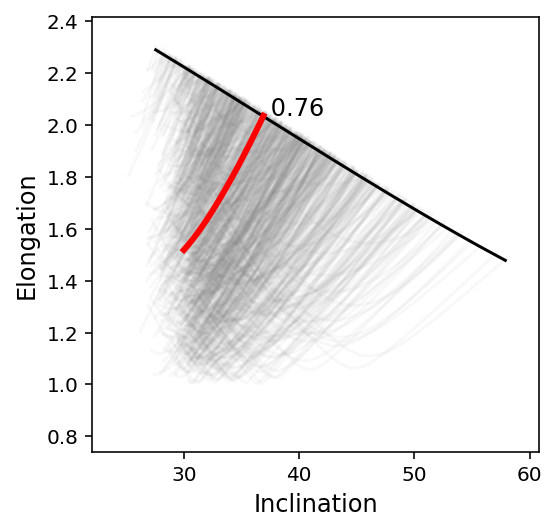

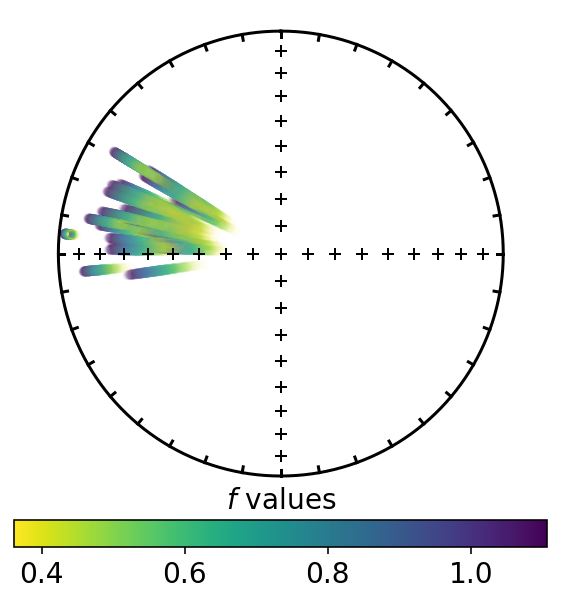

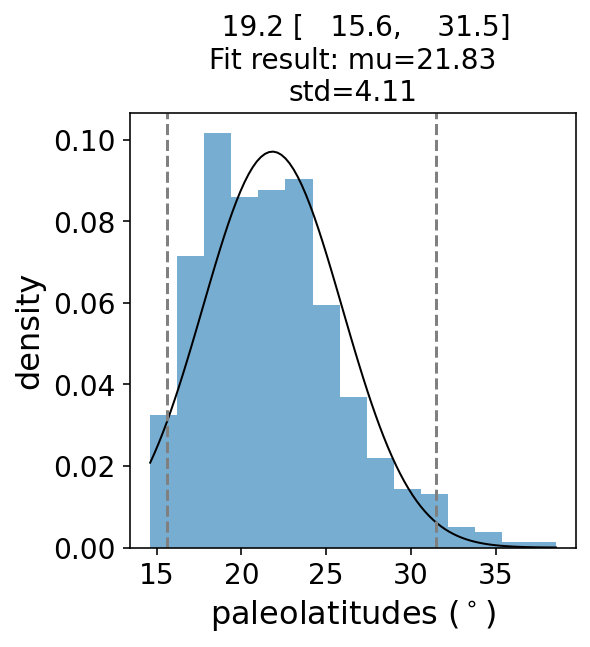

The original inclination was: 29.99

The corrected inclination is: 36.9
with bootstrapped confidence bounds of: 29.19 to 50.89
and elongation parameter of: 2.04
The flattening factor is: 0.76
with bootstrapped confidence bounds of: 1.03 to 0.47

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 183.4  Plat: 26.9
Major axis lon: 296.4  Major axis lat: 37.7
Minor axis lon: 67.7  Minor axis lat: 40.5
Major axis angle of 95% ellipse (Zeta): 10.4
Minor axis angle of 95% ellipse (Eta): 3.4
Number of directions in mean (n): 100000


In [8]:
vf_result_dir, vf_kent_stats, vf_I, vf_E, vf_F = ipmag.find_ei_kent(np.array([cf_vfs_grain.dir_dec.tolist(), cf_vfs_grain.dir_inc.tolist()]).T, 
                                                                     site_latitude=Cutface_lat, 
                                                                     site_longitude=Cutface_lon, 
                                                                     nb=1000,                 
                                                                     return_new_dirs=1,
                                                                     return_values=1,
                                                                     EI_color='r',
                                                                     resample_EI_color='grey',
                                                                     resample_EI_alpha=0.05,
                                                                     vgp_nb=100,
                                                                     cmap='viridis_r',
                                                                     central_longitude=200,
                                                                     central_latitude=20,) 

Bootstrapping.... be patient



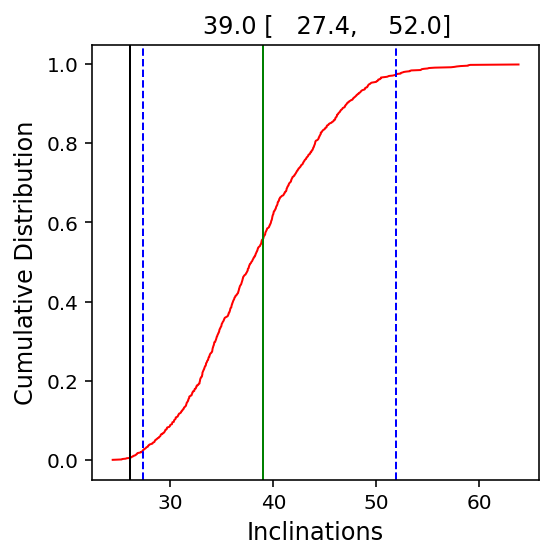

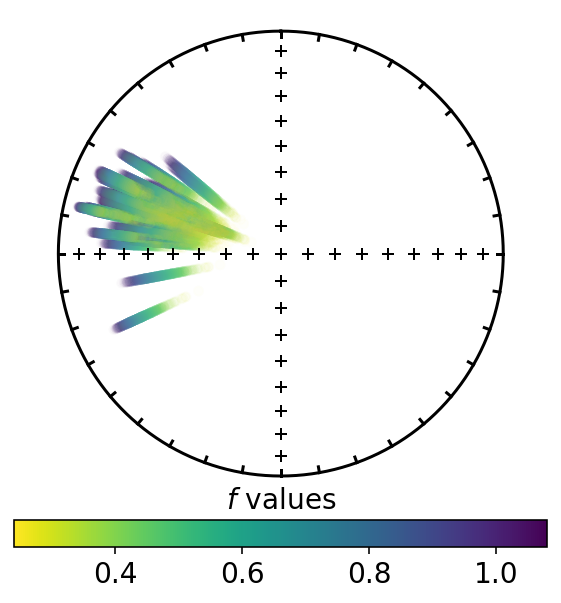

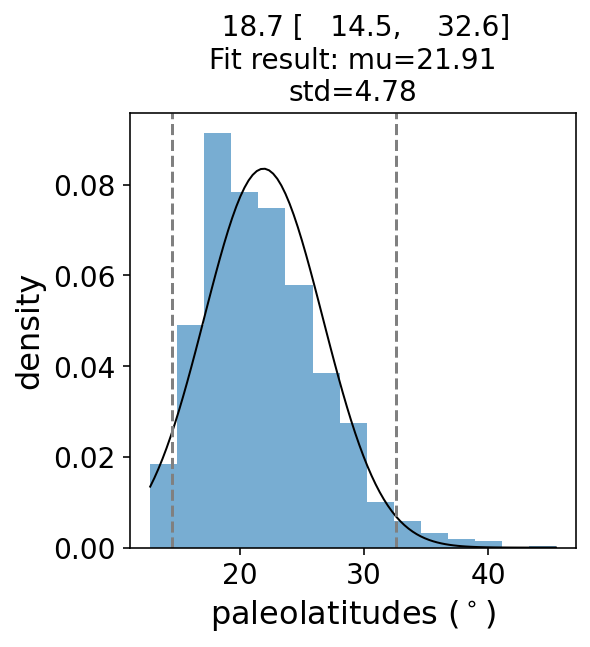

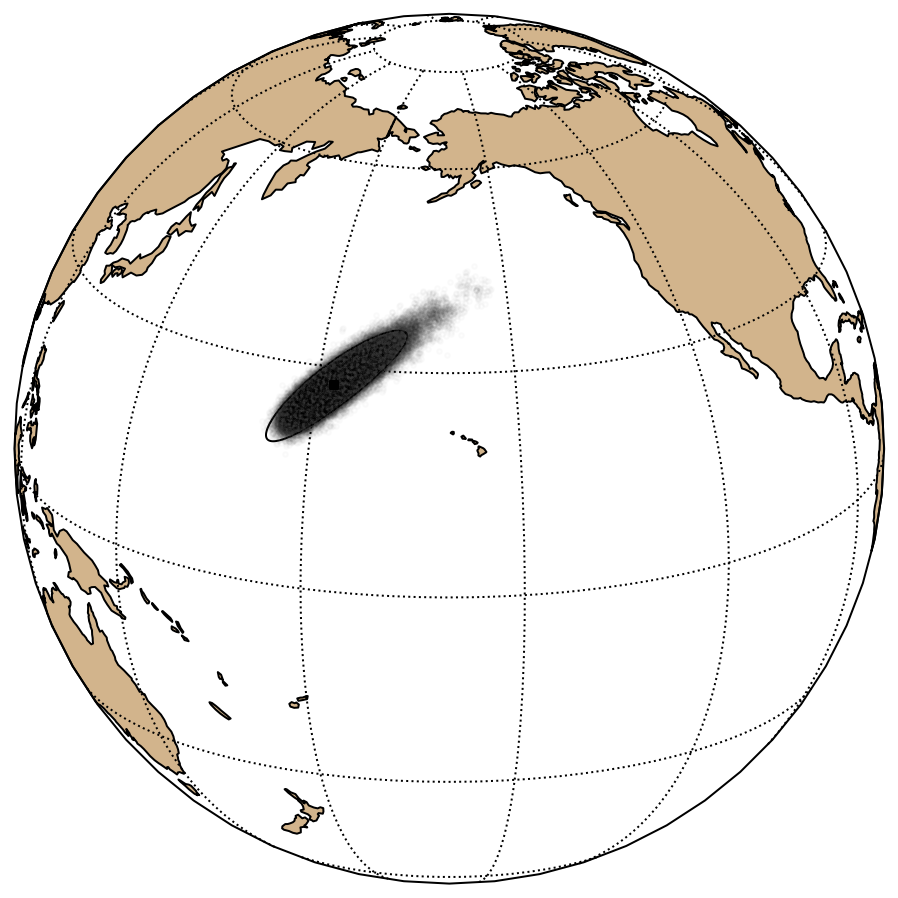

The original inclination was: 26.12

The corrected inclination is: 38.98
with bootstrapped confidence bounds of: 27.36 to 51.96
and elongation parameter of: 1.98
The flattening factor is: 0.59
with bootstrapped confidence bounds of: 0.95 to 0.38

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 182.6  Plat: 27.7
Major axis lon: 296.2  Major axis lat: 37.4
Minor axis lon: 66.4  Minor axis lat: 40.1
Major axis angle of 95% ellipse (Zeta): 11.7
Minor axis angle of 95% ellipse (Eta): 2.8
Number of directions in mean (n): 100000


In [9]:
silt_result_dir, silt_kent_stats, silt_I, silt_E, silt_F = ipmag.find_ei_kent(np.array([cf_silt_grain.dir_dec.tolist(), cf_silt_grain.dir_inc.tolist()]).T, 
                                                                     site_latitude=Cutface_lat, 
                                                                     site_longitude=Cutface_lon, 
                                                                     nb=1000,                 
                                                                     return_new_dirs=1,
                                                                     return_values=1,
                                                                     EI_color='r',
                                                                     resample_EI_color='grey',
                                                                     resample_EI_alpha=0.05,
                                                                     vgp_nb=100,
                                                                     cmap='viridis_r',
                                                                     central_longitude=200,
                                                                     central_latitude=20,) 

In [13]:
all_f_upper, all_f_lower = np.percentile(EI_fs, [95, 5])
fm_f_upper, fm_f_lower = np.percentile(fm_F, [95, 5])
vf_f_upper, vf_f_lower = np.percentile(vf_F, [95, 5])
silt_f_upper, silt_f_lower = np.percentile(silt_F, [95, 5])

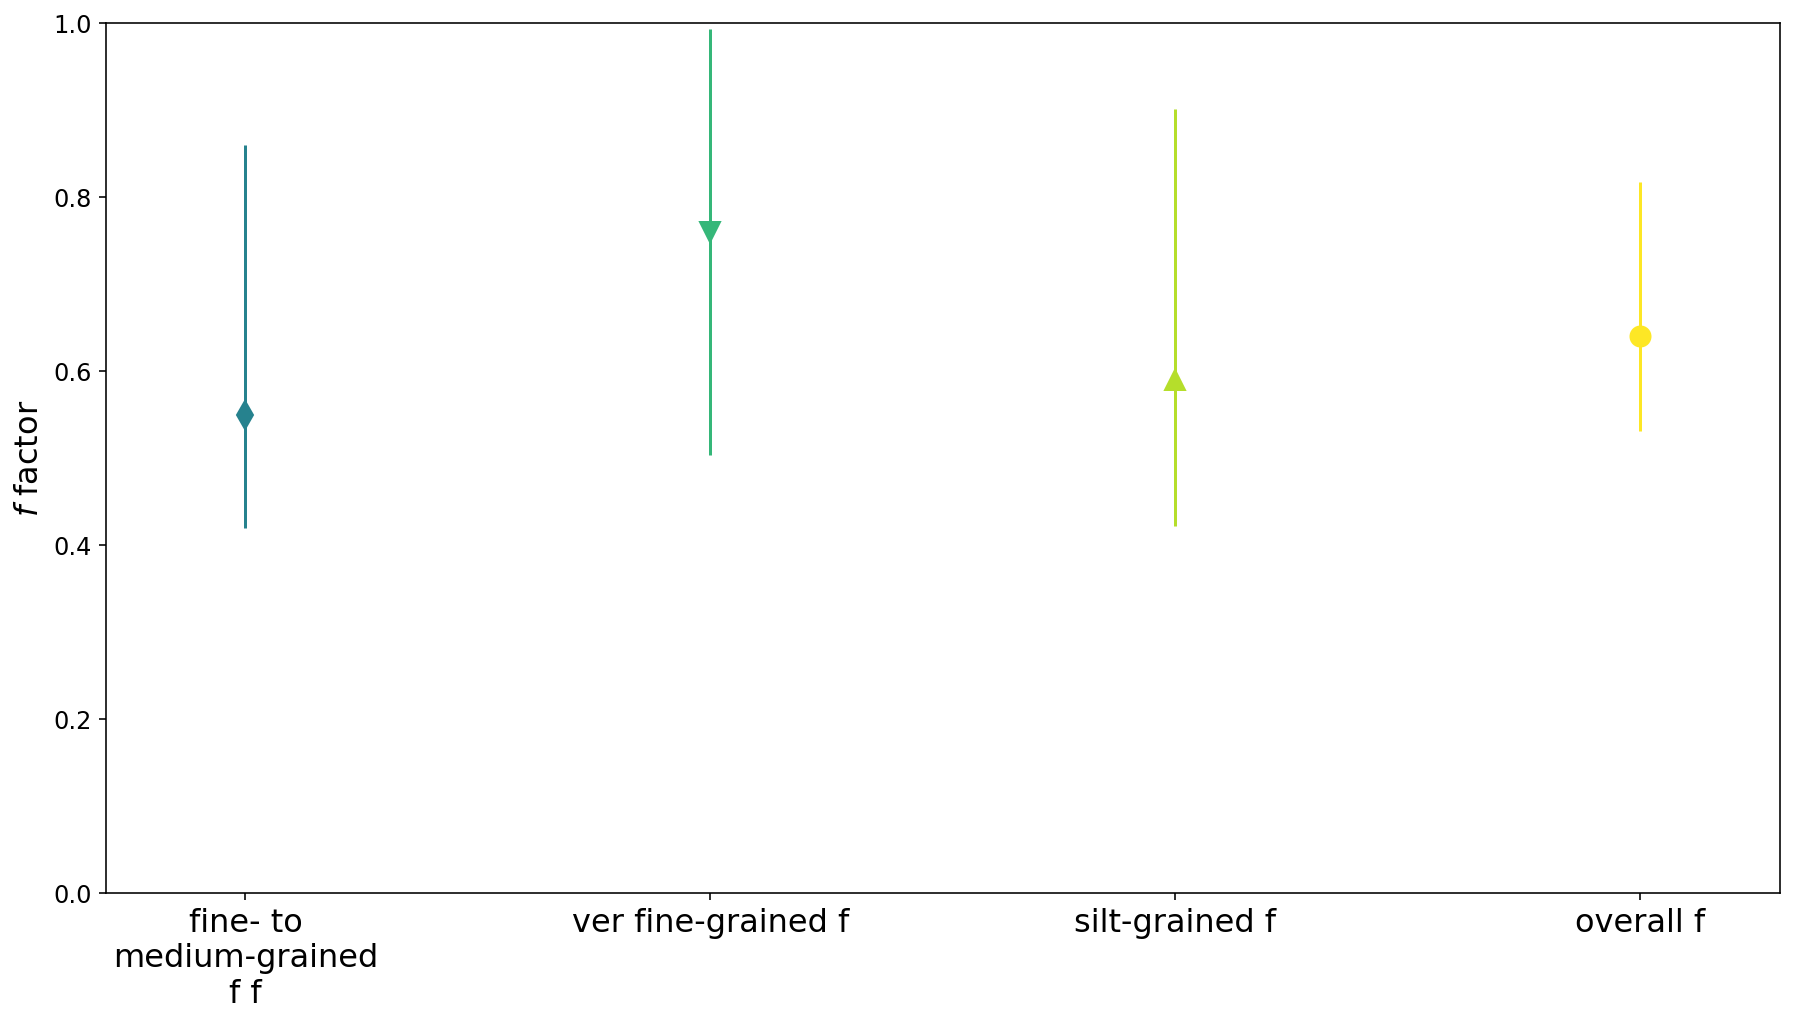

In [17]:
plt.figure(figsize=(15,8))
# plt.ylim(.35,.925)

fm_f=['fine- to\nmedium-grained\nf f']
vf_f=['ver fine-grained f']
silt_f=['silt-grained f']
all_f=['overall f']


plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=16)
plt.ylabel('$f$ factor',fontsize=16)

plt.margins(x=.1)

plt.errorbar(fm_f, 0.55, yerr=np.abs([[fm_f_lower-0.55], 
                                                 [fm_f_upper-0.55]]), 
             marker='d',markersize=10,color= viridis(4))

plt.errorbar(vf_f,0.76, 
             yerr=np.abs([[vf_f_lower-0.76], 
                          [vf_f_upper-0.76]]), 
             marker='v',markersize=10,color= viridis(6))

plt.errorbar(silt_f,0.59, 
             yerr=np.abs([[silt_f_lower-0.59], 
                          [silt_f_upper-0.59]]), 
             marker='^',markersize=10,color= viridis(8))

plt.errorbar(all_f,0.64, 
             yerr=np.abs([[all_f_lower-0.64], 
                          [all_f_upper-0.64]]), 
             marker='o',markersize=10,color= viridis(10))

plt.show()

## Difference in EI output if we were pretending that were did not have such high resolution thermal demag

Mat Domeier provided a comment on our high-resolution data that in a study that does not do such high thermal demag resolution, the mid and high-temperature steps might not be easily isolated and may result in fits that lump together/mix together some of the both components. Here we investigate how that might effect the mean direction and pole position and associated E/I analysis results. 

What we did is that we extracted temperature steps of 600, 630, 660 measurements for each specimen and did least-square line fits (anchored to origin) to the same 157 specimens as we used for the original fits.

We first show that the mean direction resulting from the "coarse fitting" approach is indeed steeper than the mean direction of the ht component that we isolate previously. This is expected in that the mt (pigmentary) component is not shallowed but were acquired soon after the deposition of the sediments.

We then compare the E/I results using the original ht component and the more coarsely fitted ht component. 

In [18]:
mean_ht = ipmag.fisher_mean(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist())
mean_ht

{'dec': 286.57662835036626,
 'inc': 29.430252935780295,
 'n': 157,
 'r': 152.6395808355861,
 'k': 35.776377021993966,
 'alpha95': 1.9070660543868,
 'csd': 13.54212566584305}

In [71]:
Cutface_coarse_fits = pd.read_csv('../data/Pmag/cutface_coarse_fit/specimens.txt', sep='\t', header=1)
Cutface_coarse_fits = Cutface_coarse_fits[(Cutface_coarse_fits['dir_comp']=='ht') & (Cutface_coarse_fits['dir_tilt_correction']==100)]

In [72]:
coarse_fit_mean_ht = ipmag.fisher_mean(Cutface_coarse_fits['dir_dec'].tolist(),Cutface_coarse_fits['dir_inc'].tolist())
coarse_fit_mean_ht

{'dec': 286.3751591648151,
 'inc': 32.272239406738336,
 'n': 157,
 'r': 154.11464606737783,
 'k': 54.066157443024515,
 'alpha95': 1.543852762526688,
 'csd': 11.015957874693106}

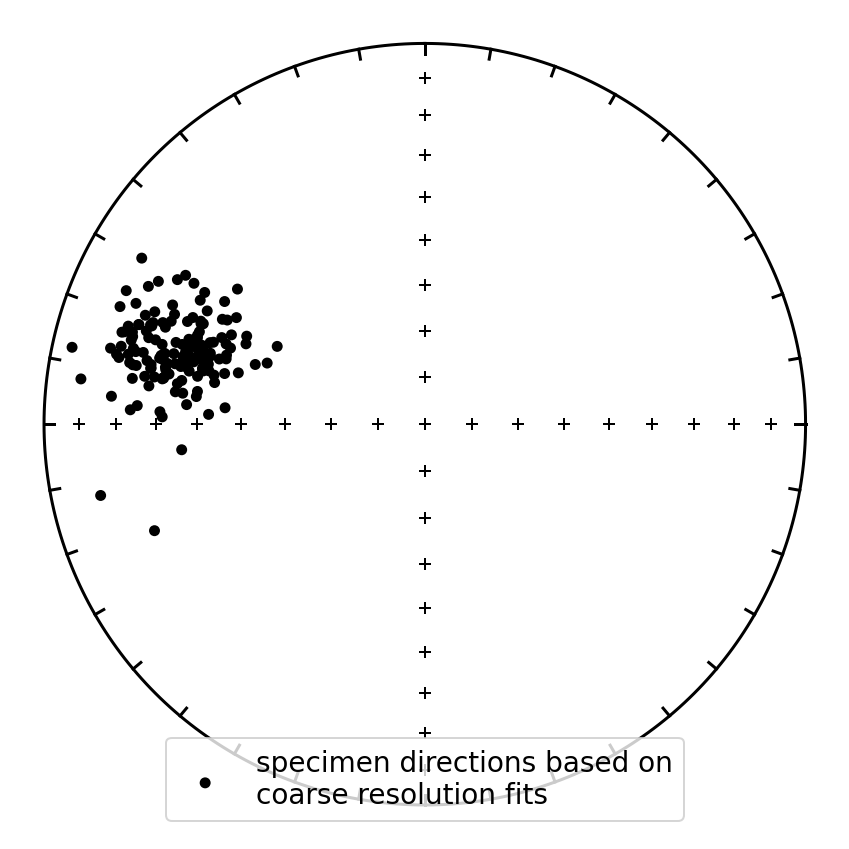

In [82]:
plt.figure(num=1,figsize=(6,6))
ipmag.plot_net(1)
ipmag.plot_di(Cutface_coarse_fits['dir_dec'].tolist(),Cutface_coarse_fits['dir_inc'].tolist(), label='specimen directions based on\ncoarse resolution fits')
plt.tight_layout()
plt.legend(loc=8, fontsize=14)
plt.savefig('code_output/coarse_fits.pdf', bbox_inches='tight')
plt.show()

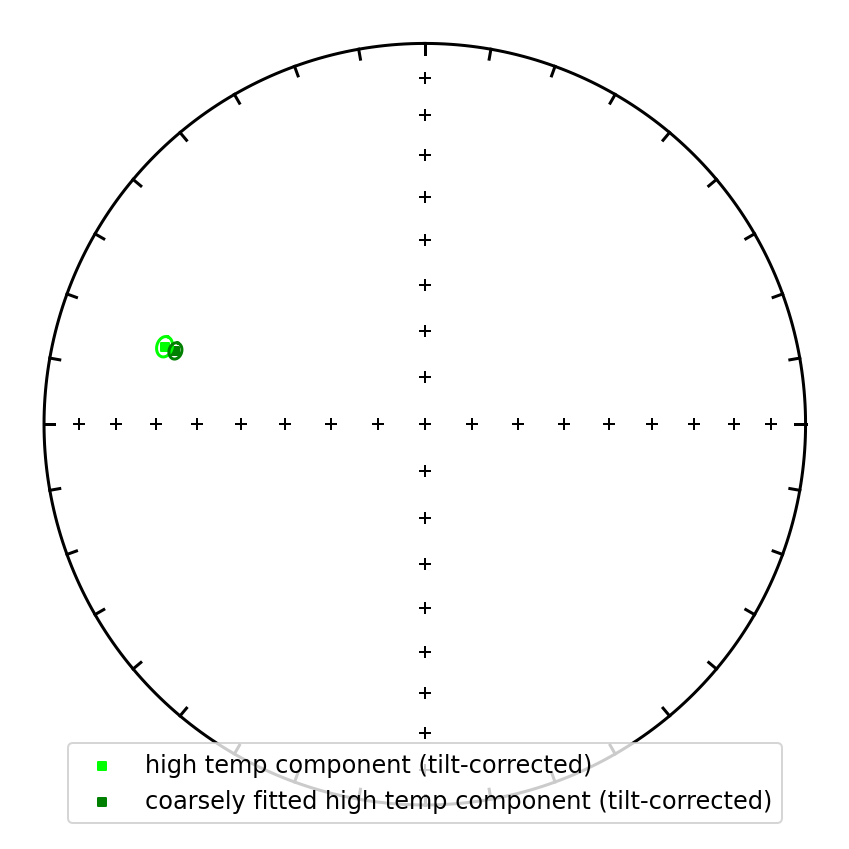

In [73]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='lime', marker = 's', label='high temp component (tilt-corrected)')
ipmag.plot_di_mean(coarse_fit_mean_ht['dec'],coarse_fit_mean_ht['inc'],coarse_fit_mean_ht['alpha95'],
                   color='green', marker = 's', label='coarsely fitted high temp component (tilt-corrected)')
plt.legend(loc=8, fontsize=12)
plt.show()

Bootstrapping.... be patient

The original inclination was: 32.31

The corrected inclination is: 34.98
with bootstrapped confidence bounds of: 32.09 to 43.23
and elongation parameter of: 2.09
The flattening factor is: 0.9
with bootstrapped confidence bounds of: 1.01 to 0.67


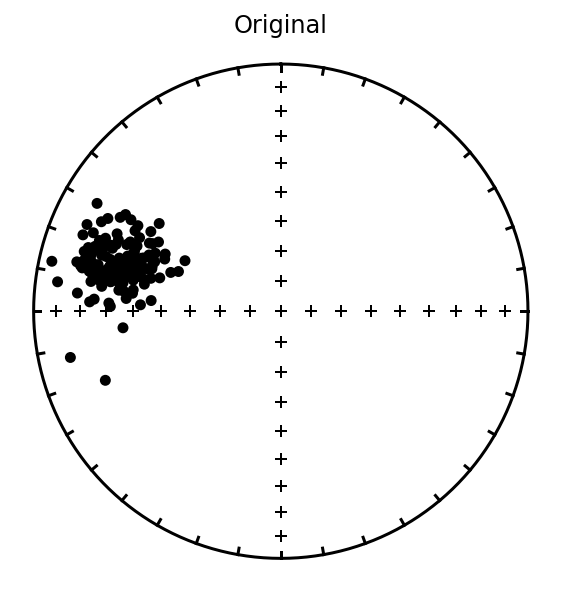

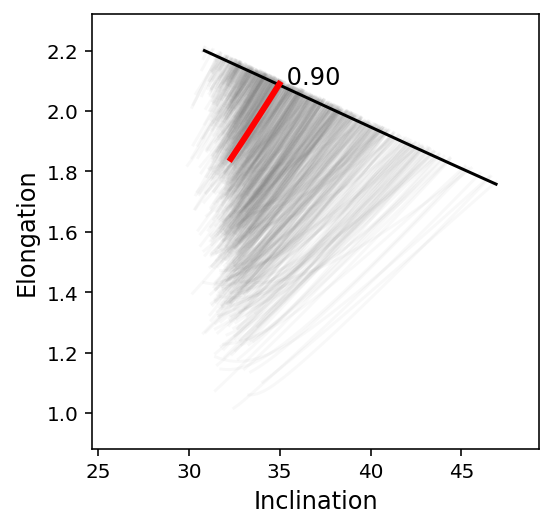

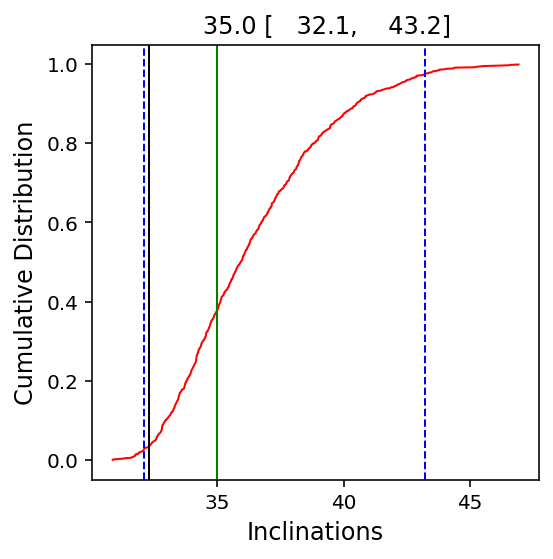

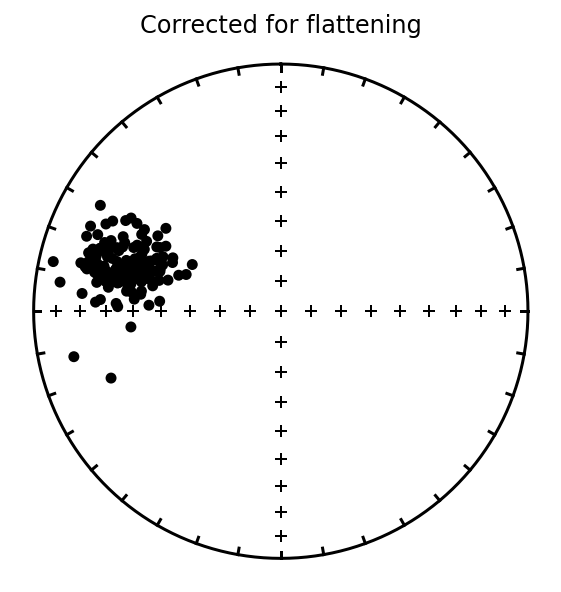

In [74]:
coarse_EI_incs, coarse_EI_elongs, coarse_EI_fs = ipmag.find_ei(Cutface_coarse_fits[['dir_dec', 'dir_inc']].to_numpy(), nb=1000, 
                                    return_values = 1, save=1, save_folder='code_output', figprefix='coarse_res', fmt='png', tight_axes=1)

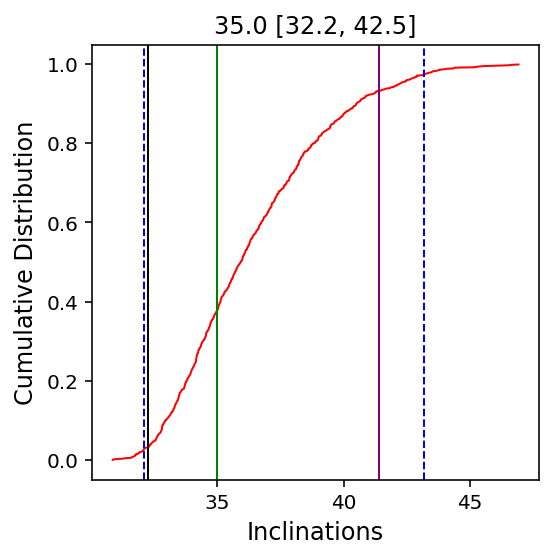

In [75]:
cdf_fig_num = 3
plt.figure(num=cdf_fig_num, figsize=(4, 4))

coarse_EI_incs_upper, coarse_EI_incs_lower = np.percentile(coarse_EI_incs, [97.5, 2.5])

pmagplotlib.plot_cdf(cdf_fig_num, coarse_EI_incs, 'Inclinations', 'r', '35.0 [32.2, 42.5]')
pmagplotlib.plot_vs(cdf_fig_num, [coarse_EI_incs_upper, coarse_EI_incs_lower], 'b', '--')
pmagplotlib.plot_vs(cdf_fig_num, [34.98], 'g', '-')
pmagplotlib.plot_vs(cdf_fig_num, [41.4], 'purple', '-')

pmagplotlib.plot_vs(cdf_fig_num, [coarse_fit_mean_ht['inc']], 'k', '-')

plt.savefig('code_output/coarse_res_EI_incs.pdf', bbox_inches='tight')

In [50]:
Cutface_coarse_fits_unsquish_inc = ipmag.unsquish(Cutface_coarse_fits['dir_inc'].tolist(), 0.9)
Cutface_coarse_fits_unsquish_mean = ipmag.fisher_mean(Cutface_coarse_fits['dir_dec'].tolist(), Cutface_coarse_fits_unsquish_inc)
Cutface_coarse_fits_unsquish_mean

{'dec': 286.3577544979628,
 'inc': 34.92541707793104,
 'n': 157,
 'r': 154.00740286011774,
 'k': 52.12863366104046,
 'alpha95': 1.5728312037458345,
 'csd': 11.218811421449614}

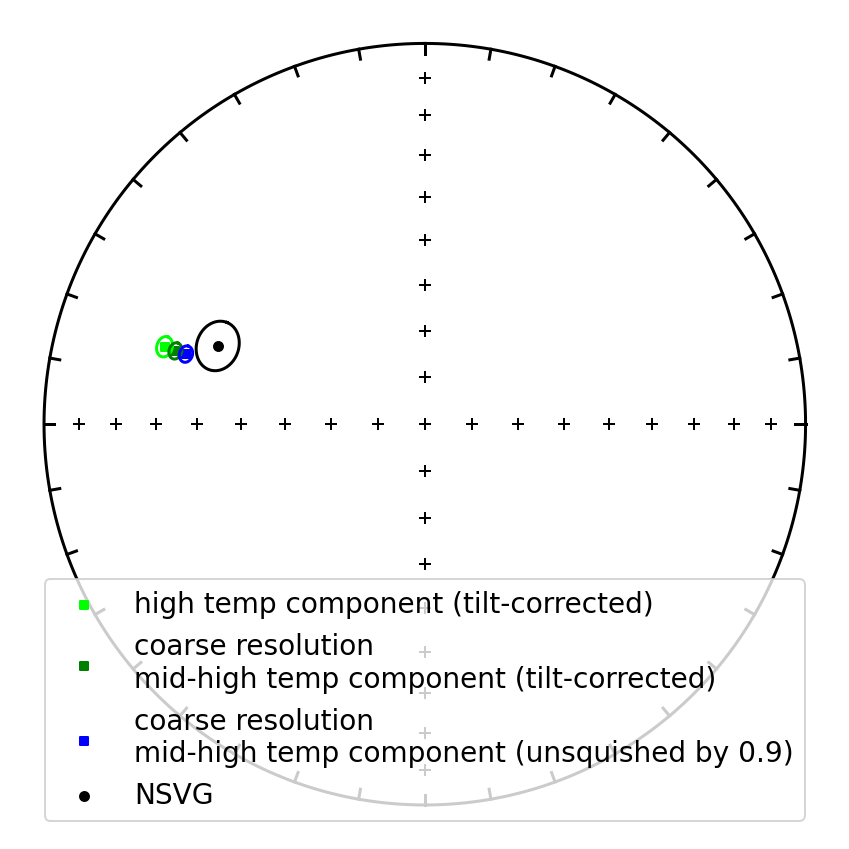

In [59]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6))
ipmag.plot_net(fignum)

ipmag.plot_di_mean(mean_ht['dec'],mean_ht['inc'],mean_ht['alpha95'],
                   color='lime', marker = 's', label='high temp component (tilt-corrected)')
ipmag.plot_di_mean(coarse_fit_mean_ht['dec'],coarse_fit_mean_ht['inc'],coarse_fit_mean_ht['alpha95'],
                   color='green', marker = 's', label='coarse resolution\nmid-high temp component (tilt-corrected)')
ipmag.plot_di_mean(Cutface_coarse_fits_unsquish_mean['dec'],Cutface_coarse_fits_unsquish_mean['inc'],Cutface_coarse_fits_unsquish_mean['alpha95'],
                   color='b', marker = 's', label='coarse resolution\nmid-high temp component (unsquished by 0.9)')
ipmag.plot_di_mean(290.7, 41.4, 4.9, label='NSVG')
plt.legend(loc=8, fontsize=14)
plt.savefig('code_output/coarse_resolution_mean_direction.pdf', bbox_inches='tight')
plt.show()

Bootstrapping.... be patient



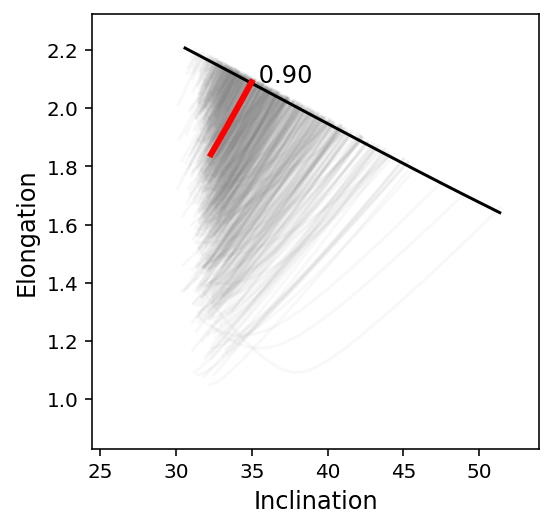

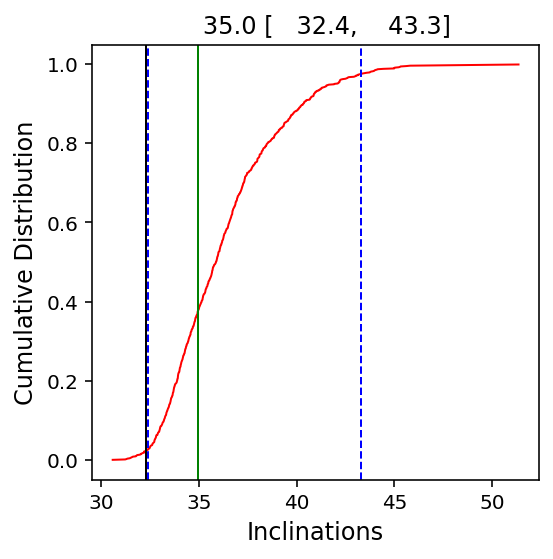

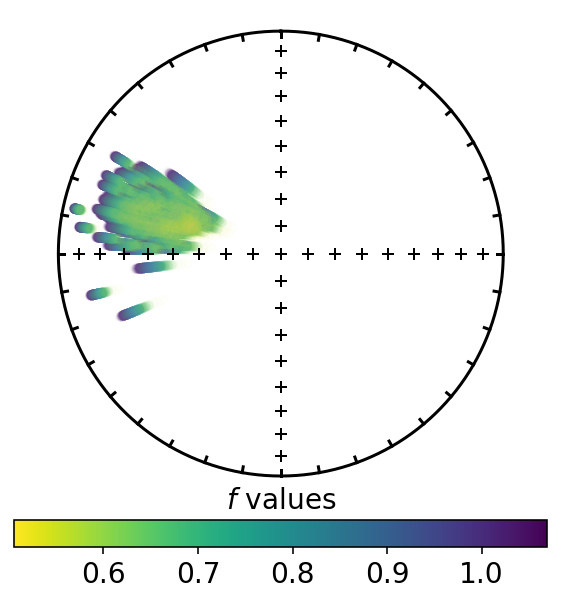

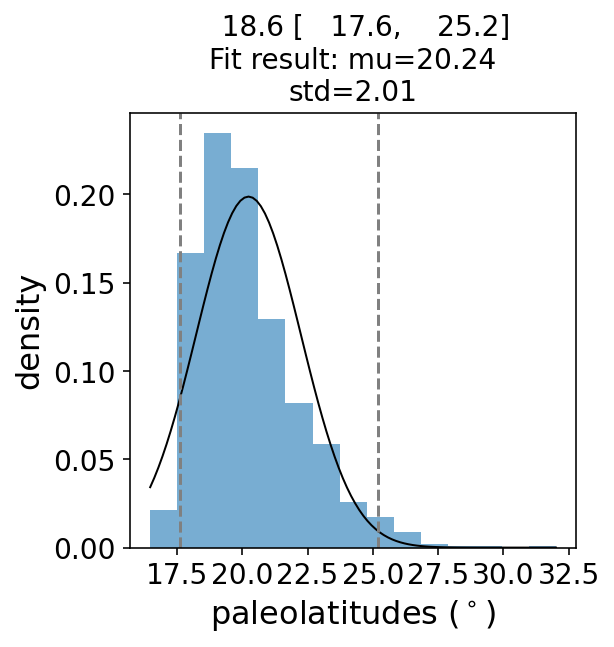

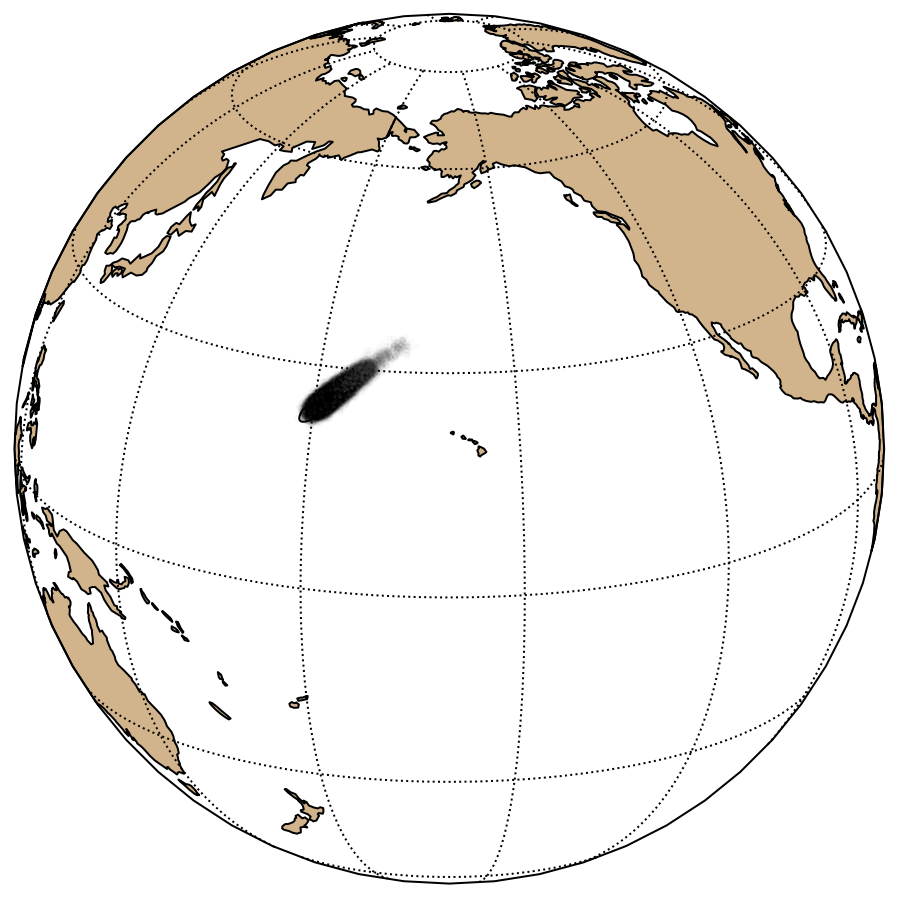

The original inclination was: 32.31

The corrected inclination is: 34.98
with bootstrapped confidence bounds of: 32.39 to 43.29
and elongation parameter of: 2.09
The flattening factor is: 0.9
with bootstrapped confidence bounds of: 1.0 to 0.67

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 182.1  Plat: 26.0
Major axis lon: 294.9  Major axis lat: 38.5
Minor axis lon: 67.5  Minor axis lat: 40.5
Major axis angle of 95% ellipse (Zeta): 5.0
Minor axis angle of 95% ellipse (Eta): 1.4
Number of directions in mean (n): 100000


In [51]:
coarse_result_dir, coarse_kent_stats, coarse_I, coarse_E, coarse_F = ipmag.find_ei_kent(Cutface_coarse_fits[['dir_dec', 'dir_inc']].to_numpy(), 
                                                                     site_latitude=Cutface_lat, 
                                                                     site_longitude=Cutface_lon, 
                                                                     nb=1000,                 
                                                                     return_new_dirs=1,
                                                                     return_values=1,
                                                                     EI_color='r',
                                                                     resample_EI_color='grey',
                                                                     resample_EI_alpha=0.05,
                                                                     vgp_nb=100,
                                                                     cmap='viridis_r',
                                                                     central_longitude=200,
                                                                     central_latitude=20,) 

In [40]:
coarse_f_upper, coarse_lower = np.percentile(coarse_EI_fs, [95, 5])

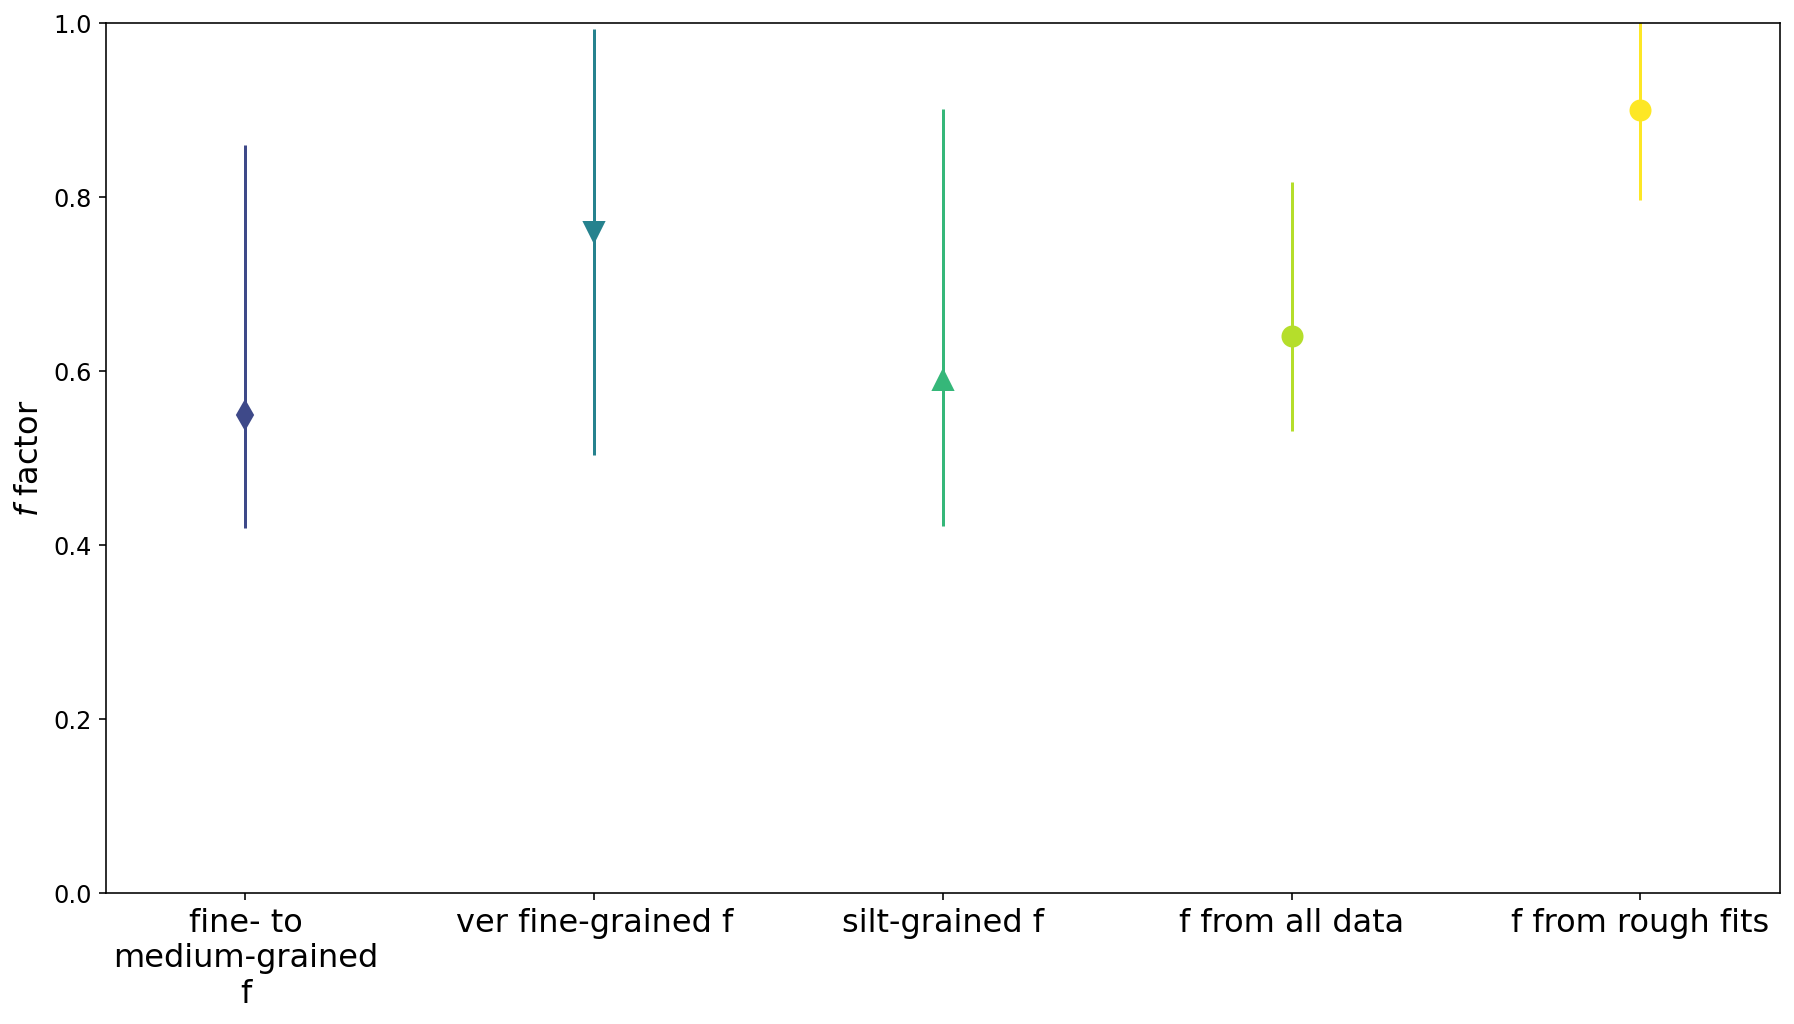

In [44]:
plt.figure(figsize=(15,8))
# plt.ylim(.35,.925)

fm_f=['fine- to\nmedium-grained\nf']
vf_f=['ver fine-grained f']
silt_f=['silt-grained f']
all_f=['f from all data']
coarse_f=['f from coarse fits']

plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=16)
plt.ylabel('$f$ factor',fontsize=16)

plt.margins(x=.1)

plt.errorbar(fm_f, 0.55, yerr=np.abs([[fm_f_lower-0.55], 
                                                 [fm_f_upper-0.55]]), 
             marker='d',markersize=10,color= viridis(2))

plt.errorbar(vf_f,0.76, 
             yerr=np.abs([[vf_f_lower-0.76], 
                          [vf_f_upper-0.76]]), 
             marker='v',markersize=10,color= viridis(4))

plt.errorbar(silt_f,0.59, 
             yerr=np.abs([[silt_f_lower-0.59], 
                          [silt_f_upper-0.59]]), 
             marker='^',markersize=10,color= viridis(6))

plt.errorbar(all_f,0.64, 
             yerr=np.abs([[all_f_lower-0.64], 
                          [all_f_upper-0.64]]), 
             marker='o',markersize=10,color= viridis(8))

plt.errorbar(coarse_f,0.9, 
             yerr=np.abs([[coarse_lower-0.81], 
                          [coarse_f_upper-0.81]]), 
             marker='o',markersize=10,color= viridis(10))
plt.show()

# Test the Kent distirbution method on synthetic data drawn from TK03 and data from Central Asia red beds

## synthetic data

In [19]:
n=150
synthetic_lat = pmag.plat(42)
synthetic_dec = mean_ht['dec']
synthetic_data = np.array(ipmag.tk03(n=n, dec=synthetic_dec, lat=synthetic_lat))

synthetic_decs = synthetic_data.T[0]
synthetic_incs = synthetic_data.T[1]

synthetic_vgp_lons = np.array([pmag.dia_vgp(synthetic_decs[i], synthetic_incs[i], 0, Cutface_lat, Cutface_lon) for i in range(n)]).T[0]
synthetic_vgp_lats = np.array([pmag.dia_vgp(synthetic_decs[i], synthetic_incs[i], 0, Cutface_lat, Cutface_lon) for i in range(n)]).T[1]
synthetic_pole = ipmag.fisher_mean(synthetic_vgp_lons, synthetic_vgp_lats)

f = 0.64
squished_incs = ipmag.squish(synthetic_incs, f)

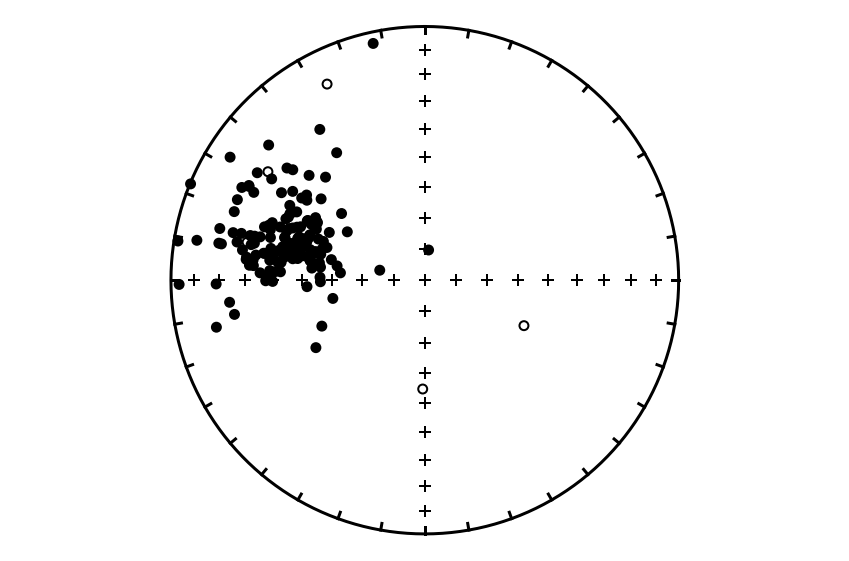

In [20]:
ipmag.plot_net()
ipmag.plot_di(synthetic_decs, synthetic_incs)

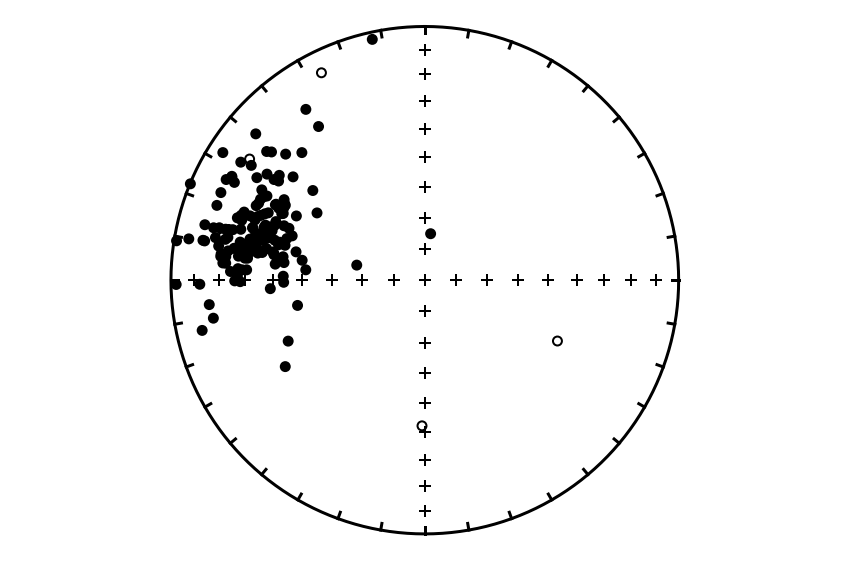

In [21]:
ipmag.plot_net()
ipmag.plot_di(synthetic_decs, squished_incs)

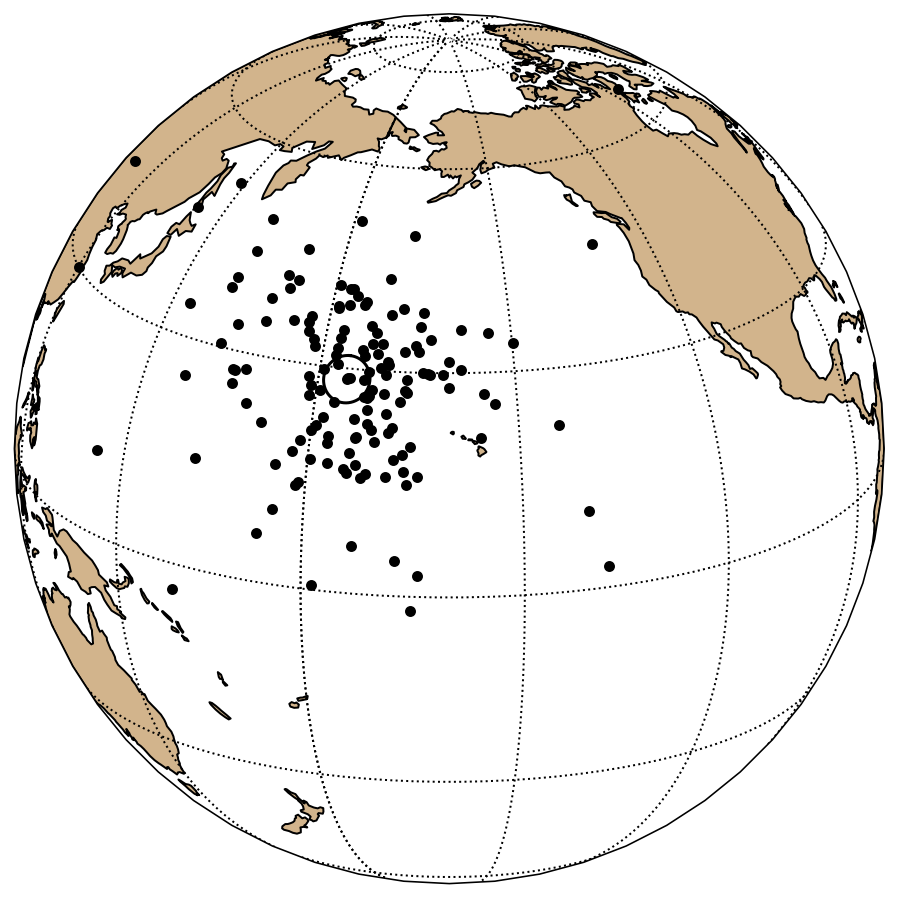

In [22]:
ax = ipmag.make_orthographic_map(200,20)
ipmag.plot_vgp(ax, synthetic_vgp_lons, synthetic_vgp_lats)
ipmag.plot_pole(ax, synthetic_pole['dec'], synthetic_pole['inc'], synthetic_pole['alpha95'])

plt.show()

Bootstrapping.... be patient



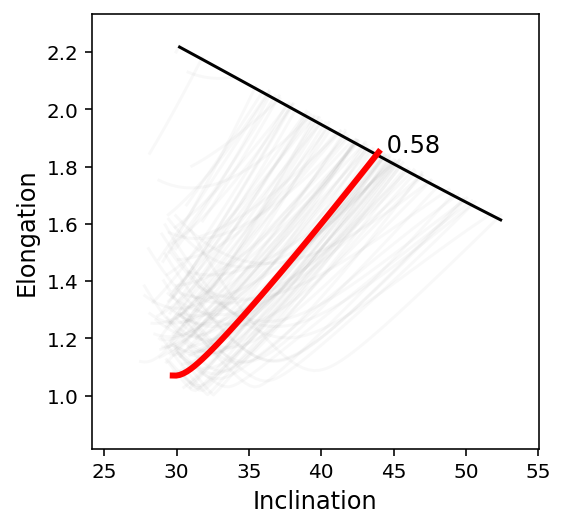

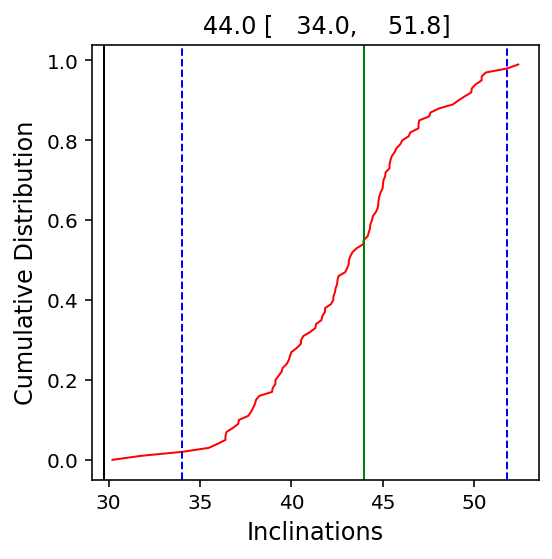

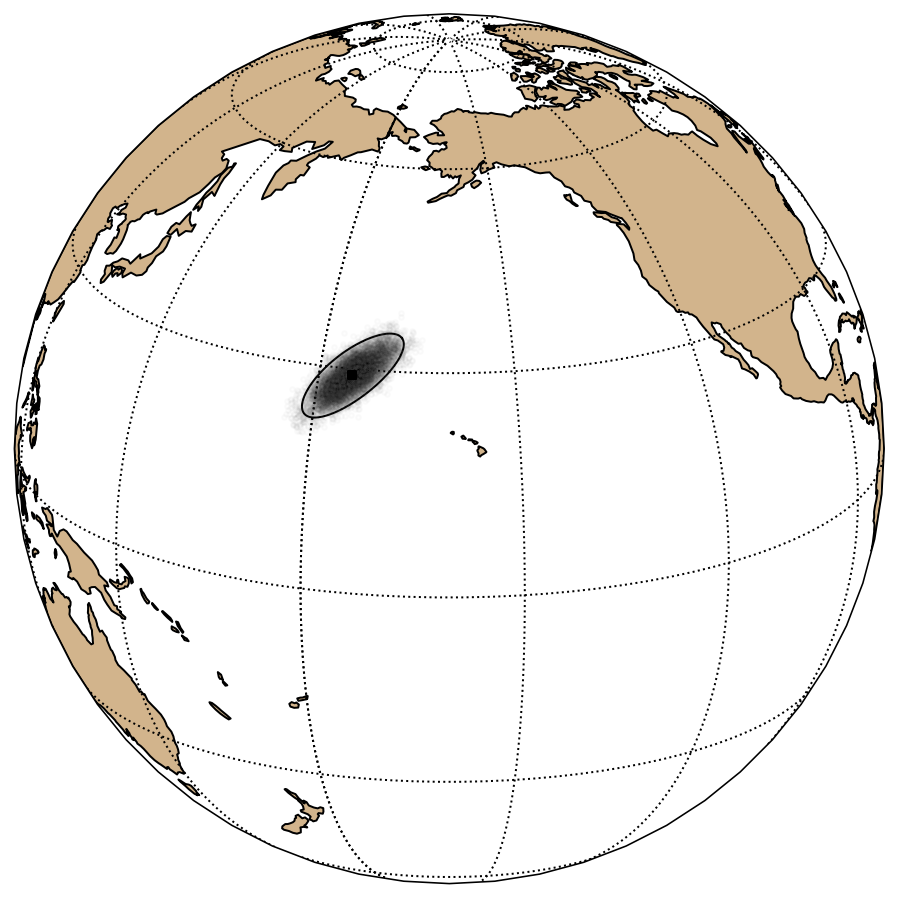

The original inclination was: 29.74

The corrected inclination is: 43.97
with bootstrapped confidence bounds of: 34.03 to 51.79
and elongation parameter of: 1.85
The flattening factor is: 0.58
with bootstrapped confidence bounds of: 0.85 to 0.45

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 185.1  Plat: 29.2
Major axis lon: 299.7  Major axis lat: 36.6
Minor axis lon: 67.6  Minor axis lat: 39.6
Major axis angle of 95% ellipse (Zeta): 8.2
Minor axis angle of 95% ellipse (Eta): 3.2
Number of directions in mean (n): 10000


In [23]:
result_dir, kent_stats, I, E, F = ipmag.find_ei_kent(np.array([synthetic_decs, squished_incs]).T, 
                                         site_latitude=Cutface_lat, 
                                         site_longitude=Cutface_lon, 
                                         nb=100,                 
                                         return_new_dirs=1,
                                         return_values=1,
                                         EI_color='r',
                                         resample_EI_color='grey',
                                         resample_EI_alpha=0.05,
                                         vgp_nb=100,
                                         cmap='viridis_r',
                                         central_longitude=200,
                                         central_latitude=20,) 

## Test the method on Li et al., 2020 data compiled by Vaes et al, 2021

In [62]:
Li2020a_slat = 30.85
Li2020a_slon = 98.3
Li2020a = pd.read_csv('../data/data_compiled/Li2020a.csv')
Li2020a_lower_interval = Li2020a[Li2020a['depth']<=382.2].reset_index(drop=1)
# Li2020a['DEC'] = [Li2020a['Ds'][i] if Li2020a['Is'][i]>=0 else (Li2020a['Ds'][i]+180)%360 for i in range(Li2020a.shape[0])]
# Li2020a['INC'] = [Li2020a['Is'][i] if Li2020a['Is'][i]>=0 else -Li2020a['Is'][i] for i in range(Li2020a.shape[0])]
Li2020a_lower_interval.head()

sample     #  depth    Dg    Ig    Ds    Is   Lat    Lon
0  GJ184  1109  382.2  76.7  23.8  78.4   8.8  12.2  190.4
1  GJ183  1110  380.2  74.7  33.0  77.6  18.2  15.4  186.5
2  GJ182  1111  378.2  45.3  36.3  52.6  25.8  38.9  195.8
3  GJ181  1112  375.2  42.6  15.2  45.0   5.9  39.3  212.5
4  GJ180  1113  373.2  34.7  25.2  40.2  17.3  46.6  210.1

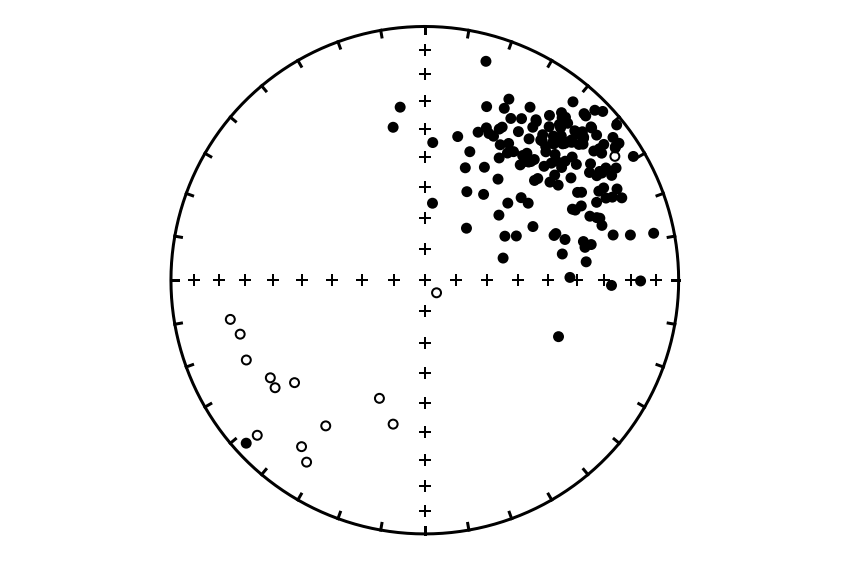

In [61]:
ipmag.plot_net()
ipmag.plot_di(Li2020a_lower_interval['Ds'], Li2020a_lower_interval['Is'])

In [84]:
Li2020a_lower_interval_flip = pmag.flip(ipmag.make_di_block(Li2020a_lower_interval['Ds'], Li2020a_lower_interval['Is']), combine=1)
# Li2020a_lower_interval_flip

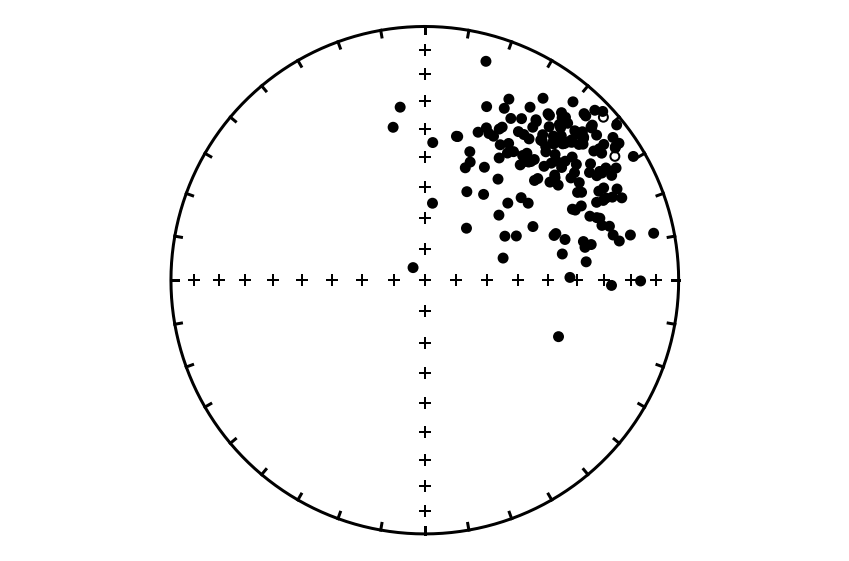

In [85]:
ipmag.plot_net()
ipmag.plot_di(di_block=Li2020a_lower_interval_flip)

Bootstrapping.... be patient



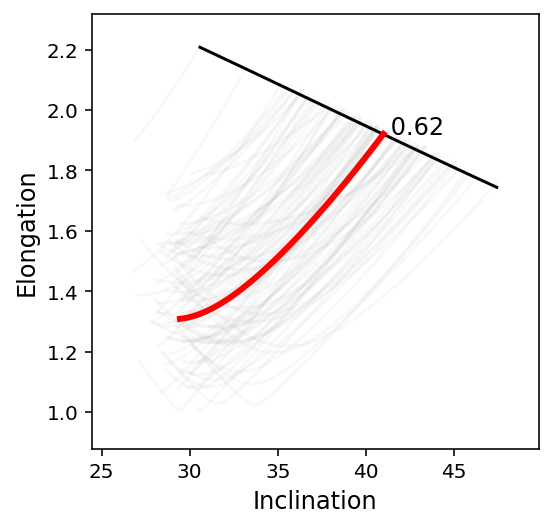

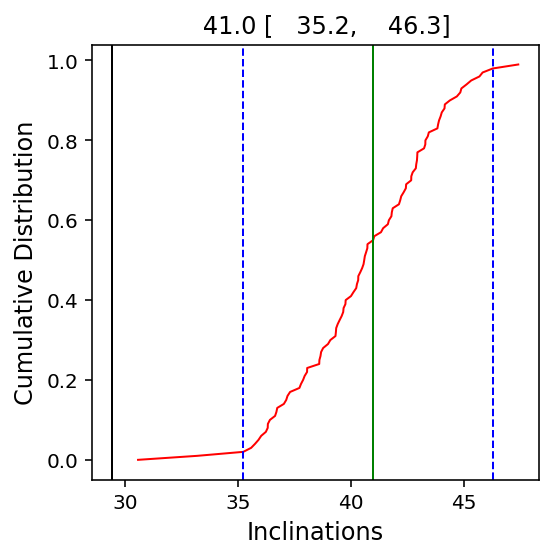

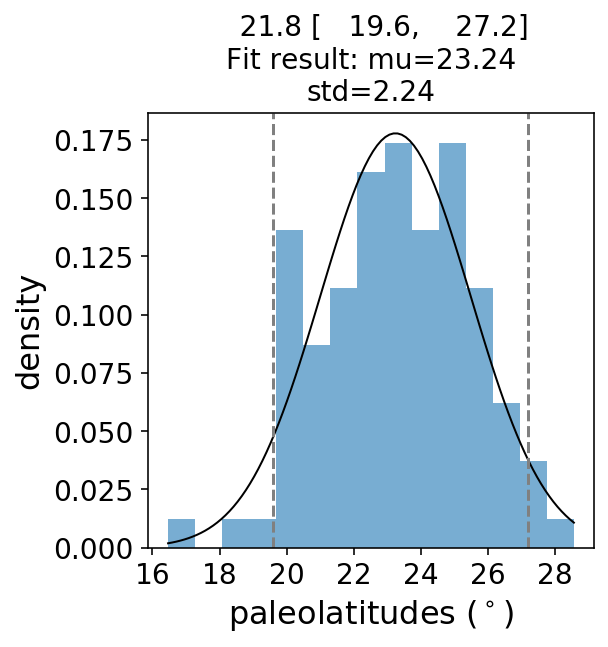

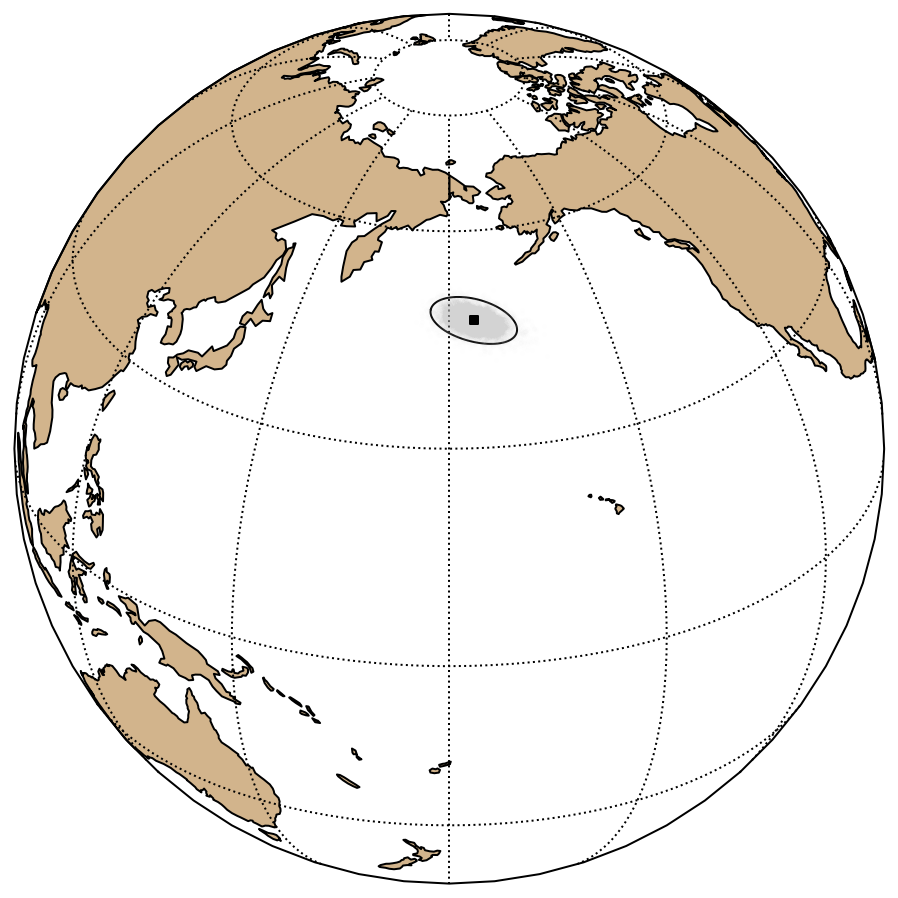

The original inclination was: 29.45

The corrected inclination is: 41.0
with bootstrapped confidence bounds of: 35.25 to 46.3
and elongation parameter of: 1.92
The flattening factor is: 0.62
with bootstrapped confidence bounds of: 0.8 to 0.54

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 184.8  Plat: 47.1
Major axis lon: 81.0  Major axis lat: 12.5
Minor axis lon: 340.3  Minor axis lat: 40.2
Major axis angle of 95% ellipse (Zeta): 5.9
Minor axis angle of 95% ellipse (Eta): 2.9
Number of directions in mean (n): 10000


In [89]:
Li2020a_result_dir, Li2020a_kent, Li2020a_I, Li2020a_E, Li2020a_F = ipmag.find_ei_kent(Li2020a_lower_interval_flip, 
                                                                            site_latitude=Li2020a_slat, 
                                                                            site_longitude=Li2020a_slon, 
                                                                            nb=100,
                                                                            return_new_dirs=1,
                                                                            return_values=1,
                                                                            EI_color='r',
                                                                            resample_EI_color='grey',
                                                                            resample_EI_alpha=0.05,
                                                                            vgp_nb=100,
                                                                            cmap='viridis_r',
                                                                            central_longitude=180,
                                                                            central_latitude=30,) 